# REST API

In modern distributed systems, especially those powering the web and the Internet of Things (IoT), effective communication between components is essential. One of the most prominent paradigms for building such systems is the **Representational State Transfer** (REST) architecture. REST is not a protocol but a set of architectural principles that guide the design of scalable, simple, and robust systems based on web standards, particularly HTTP.

REST was formalized by Roy Fielding in his doctoral dissertation and has since become the foundation of most web services. It emphasizes the use of **resources** (identifiable pieces of data) and defines standard operations over these resources using HTTP methods like GET, POST, PUT, and DELETE. Unlike older models such as **Remote Procedure Call (RPC)**, where communication mimics traditional function calls, REST abstracts these interactions in a way that aligns with the design of the World Wide Web itself.

At the heart of REST lies the idea of leveraging a **uniform interface**. This uniformity ensures that clients and servers can interact without prior knowledge beyond the shared understanding of resource URIs and HTTP semantics. RESTful systems follow constraints such as statelessness, cacheability, and a layered system design, which contribute to their performance and scalability.

Each interaction in a RESTful API revolves around the representation of a resource. A resource is an abstract concept — a user, a sensor reading, a transaction — and its representation is typically a document encoded in a standard format like JSON. These representations are self-descriptive, meaning they include metadata that allows clients to understand how to process them without relying on out-of-band information.

A RESTful approach becomes even more powerful when coupled with **hypermedia**, a principle known as HATEOAS (Hypermedia as the Engine of Application State). This allows clients to dynamically discover actions they can take by following links embedded in the responses, much like how users navigate the web.

Today, REST APIs form the backbone of web services provided by companies like Twitter, PayPal, and eBay. They also underpin the emerging **Web of Things (WoT)**, enabling physical devices to be integrated into the web using the same architectural principles. However, REST alone is not always sufficient, especially in real-time scenarios. For these cases, extensions such as WebHooks, long polling, and WebSockets are used to push updates from servers to clients, enabling responsive, event-driven applications.

## Remote Procedure Call

Remote Procedure Call, or RPC, is a communication pattern used in distributed systems that enables a client to execute code on a remote server as if it were invoking a local function. The idea is to hide the complexity of the network by encapsulating the function invocation into a message, sending it to a remote endpoint, and then unpacking the result once the server responds. Unlike REST, which is built around resources and HTTP semantics, RPC is centered around procedures and parameter passing.

In a typical RPC interaction, the client and server agree on a set of callable procedures. When the client calls one of these procedures, a message is constructed that includes the procedure name and its arguments. This message is sent over the network to the server. Upon receiving it, the server decodes the request, executes the corresponding function, and returns the result back to the client. From the client’s point of view, it is as if a local function has returned a value, even though the execution happened elsewhere.

### RPC over HTTP: server side

While traditional RPC frameworks define their own transport and message formats, modern web technologies allow RPC to be implemented using HTTP and JSON. This approach is less efficient than binary protocols like gRPC but is very accessible and easy to prototype, especially in JavaScript environments such as Node.js.

Consider a simple use case: a client wants to add two numbers using a function hosted on a remote server. The client sends a message that specifies a method name ("add") and a list of parameters (two numbers). The server reads this request, invokes the corresponding function, and returns the result. To implement this server, we use the Express framework. The server defines a single endpoint, `/rpc`, which handles all procedure calls. Inside this handler, the server checks the method name provided in the request body and dispatches the call to the appropriate function (see 01.rpc/server.js code):

In [ ]:
const express = require('express');
const app = express();

app.use(express.json());

// Example RPC method
function add(a, b) {
  return a + b;
}

// RPC endpoint
app.post('/rpc', (req, res) => {
  const { method, params } = req.body;
  
  // Validate method and parameters
  if (method === 'add' && Array.isArray(params) && params.length === 2) {
    const result = add(params[0], params[1]);
    res.json({ result });
  } 

  // Handle other methods or invalid input
  else {
    res.status(400).json({ error: 'Invalid method or parameters' });
  }
});

// Start the server
app.listen(3000, () => { console.log('RPC server running at http://localhost:3000');});

In this code, the function add() is a local JavaScript function that simply returns the sum of two numbers. The server expects a POST request with a JSON body that includes the field "method", set to "add", and a "params" array with two numeric values. If the conditions are met, the function is executed and the result is returned as JSON.

### RPC client

On the client side, we perform the HTTP POST request. The client constructs a JSON object that mirrors a remote procedure call and sends it to the server (see 01.rpc/client.js code))

In [ ]:
const http = require('http');

// Client-side code to call the RPC method
function remoteAdd(a, b) {
  
    // Create a JSON-RPC request
    const data = JSON.stringify({
        method: 'add',
        params: [a, b]
    });

    // Set up the HTTP request options
    const options = {
        hostname: 'localhost',
        port: 3000,
        path: '/rpc',
        method: 'POST',
        headers: {
            'Content-Type': 'application/json',
            'Content-Length': Buffer.byteLength(data)
        }
    };

    // Make the HTTP request
    const req = http.request(options, res => {
        let body = '';

        res.on('data', chunk => {
            body += chunk;
        });

        res.on('end', () => {
            try {
                const parsed = JSON.parse(body);
                if (res.statusCode === 200) { console.log('Result from RPC call:', parsed.result); } 
                else { console.error('RPC Error:', parsed.error); }
            } 
            catch (err) { console.error('Error parsing response:', err.message); }
        });
    });

    req.on('error', err => { console.error('Request error:', err.message);});

    req.write(data);
    req.end();
}

// Example of calling the remote method
remoteAdd(7, 5);


This client defines a function remoteAdd() which internally sends a POST request to the RPC server. The request body contains the method name "add" and the parameters "[7, 5]". When the server processes the request and responds, the client prints the result.

### Limitations

The client and server must both know the exact name of the method and the structure of its parameters. There is no standardized way to describe or discover available methods, and HTTP features such as method semantics, status codes, and caching are underutilized. These limitations lead to tight coupling between the client and server, making the system harder to evolve and less interoperable with other services.

By contrast, REST proposes a different model, where interaction is structured around named resources, standard HTTP methods, and hypermedia-driven navigation. The next chapter will introduce the foundational principles of REST and demonstrate how the same problem—adding two numbers—can be modeled using RESTful design.

## Architectural principles

Representational State Transfer, or REST, is a set of architectural principles designed for building distributed systems that scale well and are easy to maintain over time. Although often associated with web APIs, REST is more than a programming technique or communication protocol, it is an architectural style that defines how networked components should interact. 

At its core, REST is not a technology but a model: it defines a set of constraints that, if fully respected, result in what is known as a **RESTful** system. Systems that implement these constraints benefit from scalability, reduced latency, simpler interfaces, and independent deployment of components. REST achieves this by advocating a particular way of structuring interactions around resources, standard operations, and stateless communication.

The reason REST has had such a profound impact is that it captures the very nature of the Web itself. The success of the Web is due not to any specific implementation, but to the uniformity, modularity, and simplicity of its architecture. By following the same principles, developers can build applications and services that inherit these same benefits: robustness, flexibility, and universality.

The REST architectural style is defined by five mandatory constraints. Each constraint contributes to the overall architecture by guiding how components interact and what rules they must follow to remain loosely coupled and interoperable.

### Constraint 1: Client-Server

The client-server constraint defines a clear separation between two roles in a distributed system: the **client**, which initiates requests for services or resources, and the **server**, which processes those requests and returns the appropriate responses. This division creates a boundary of responsibility and establishes a communication model that is both simple and powerful:

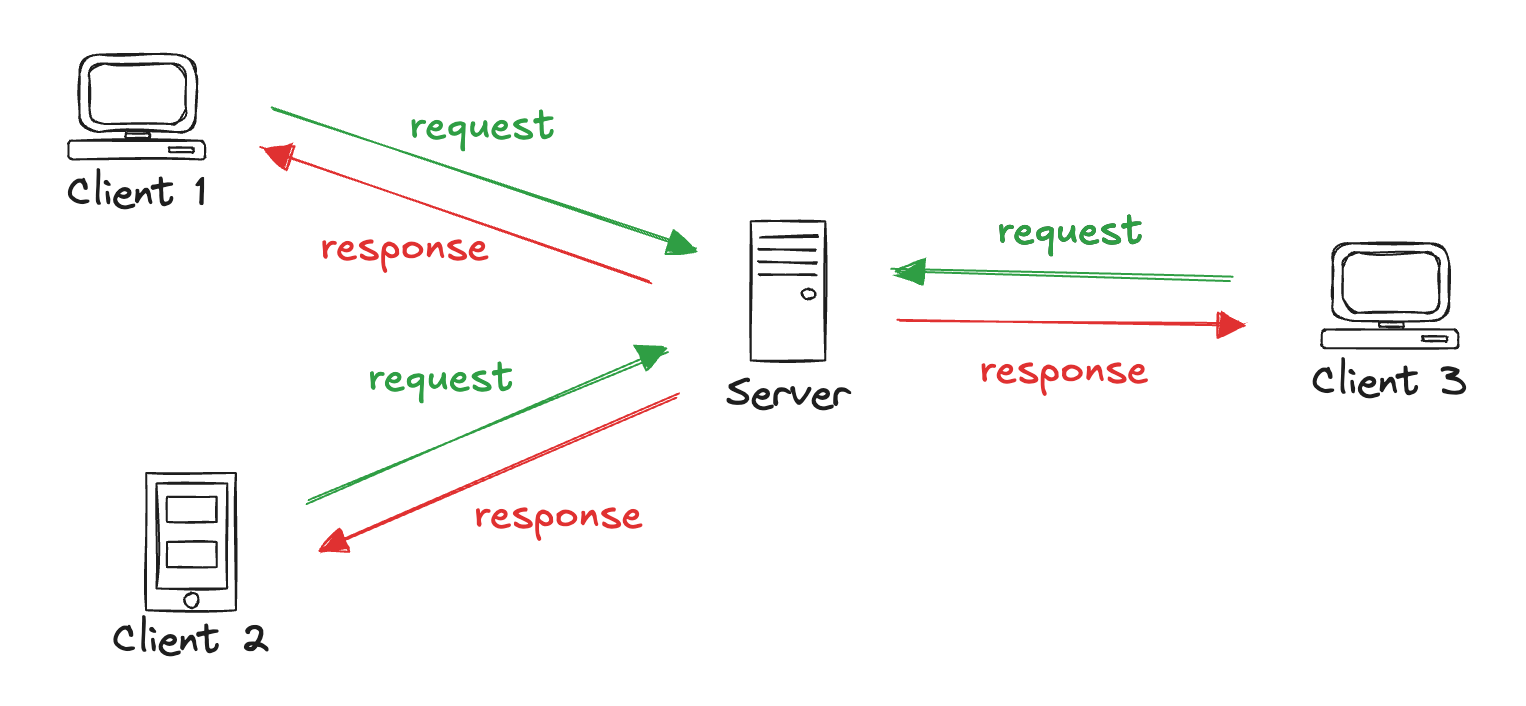

In practical terms, every interaction in a RESTful system follows the **request-response pattern**. A client constructs a request that includes a target resource (typically identified by a URI) and sends it over the network. The server receives this request, performs the necessary processing (such as retrieving data, creating or modifying resources) and returns a response that includes the result of the operation, often encoded as a JSON document. This model is the same one used by the World Wide Web, where browsers request web pages and servers respond with HTML content.

The most important effect of the client-server constraint is the **decoupling** of responsibilities. Clients do not need to understand how the server is implemented, how it stores data, or how it makes decisions internally. They only need to know what URIs to call and what format to use for their requests. Similarly, servers are not concerned with the inner workings of clients. They respond to standardized requests and leave the interpretation, display, and user interaction to the client side.

This separation has profound implications for system design. First, it promotes **loose coupling**, which means that clients and servers can evolve independently. A server can change its internal logic, upgrade its storage engine, or migrate to a different platform without requiring any changes on the client side, as long as the interface remains consistent. Likewise, a client application can switch between different servers or update its user interface without modifying the server. This flexibility is essential for building scalable, maintainable, and long-lived systems.

Another benefit of the client-server model is the **separation of concerns**. With distinct roles, each side of the communication can specialize in different tasks. The server focuses on data processing, storage, and security, while the client takes care of control logic and presentation. This makes it easier to organize teams, modularize code, and reason about system behavior. It also leads to **portability**, since clients can be implemented on any device or platform, from smartphones and web browsers to embedded sensors, as long as they can send and receive HTTP requests.

In REST, this architectural constraint is not merely a guideline, it is a structural principle. It defines the nature of the system and determines how all the other constraints (such as statelessness, cacheability, and layering) build upon this foundation. The Web itself is the ultimate proof of its success: billions of independent clients interact with countless servers every day, with no shared assumptions beyond a set of agreed-upon standards and interfaces.

By respecting the client-server boundary, RESTful systems achieve robustness, modularity, and simplicity. Each component can exist and evolve on its own terms, leading to distributed architectures that are resilient to change, open to integration, and ready to scale.

### Constraint 2: Uniform Interface

The uniform interface constraint defines how components within a distributed system interact and exchange information in a consistent, predictable way. REST mandates that all interactions between clients and servers should conform to a uniform set of rules and conventions. This constraint enables loose coupling between components, which is essential for building systems that are scalable, evolvable, and interoperable.

At its core, the uniform interface simplifies communication. Clients do not need to know the internal logic or structure of a server, nor do they need a specialized protocol to access different services. They only need to understand a small set of standard operations and how to interpret resource representations. In REST, this standard interface is implemented using the semantics of HTTP: clients interact with resources identified by URIs and perform operations on them using well-defined methods such as GET, POST, PUT, and DELETE.

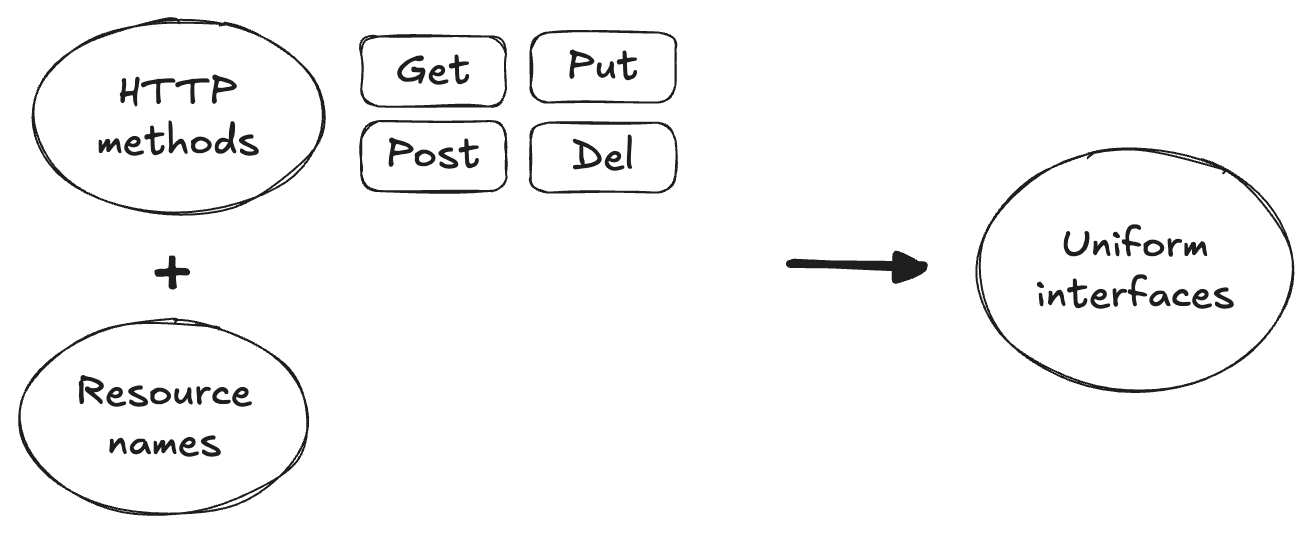

This simplicity is not a limitation but a strength. By constraining the interface, REST promotes **generality**, making it easier to build tools, intermediaries, and libraries that can interact with any RESTful service. It also enhances **extensibility**: since the interface is consistent and self-descriptive, new content types and resource representations can be introduced without changing the communication model. This is one of the reasons why the Web has succeeded as a massively distributed and heterogeneous system.

A uniform interface also plays a crucial role in enabling **automation** and **discovery**. Since the behavior of the system is predictable, clients can be written to interact with servers they have never seen before. This is especially important in the Web of Things, where new devices and services may appear dynamically, often without human intervention. In such an environment, each device should expose its functionality using the same conventions as any other web resource. This allows clients to discover, access, and manipulate devices with minimal configuration or custom logic.

Different HTTP methods correspond to specific actions on resources. A GET request retrieves the representation of a resource. A POST request creates a new resource or triggers a subordinate process. A PUT request updates an existing resource, and a DELETE request removes it. This method-resource matrix is the foundation of the uniform interface. It abstracts application behavior into a small, well-understood vocabulary that can be reused across domains, from web pages and social media APIs to sensors and actuators in smart environments.

The uniform interface also implies that messages exchanged in the system are **self-descriptive**. Each message contains enough information to describe how it should be processed, independently of the context in which it was sent. This means that intermediaries, such as caches, proxies, and gateways, can inspect, route, and even transform messages without needing to understand the application’s internal logic. This further enhances the modularity and robustness of RESTful systems.

In summary, the uniform interface constraint is what allows REST to scale across domains, platforms, and use cases. It removes the need for custom protocols or tight integration, enabling openness and broad participation. In REST, uniformity is not about rigidity; it is about creating a **shared language** that all components can understand and extend. Just as the Web allows people to publish and consume information from anywhere in the world, REST allows systems to interact and evolve in an open, consistent, and collaborative manner.

### Constraint 3: Stateless

The stateless constraint defines how client-server interactions should be structured. According to this principle, each request from a client to a server **must contain all the information necessary to understand and process that request**. This means that the server does not store any context or session information about the client between different requests. Every client request is treated as an **independent transaction**, with no reliance on information from previous interactions.

This design choice offers several significant advantages. First, it enhances the **visibility** of the system. Since each request is self-contained, developers and system administrators can more easily trace, monitor, and debug client-server communication. Every request reveals its full intent, making logs and monitoring tools more informative and meaningful.

Second, the stateless nature of interactions improves **robustness**. In systems where the server does not retain session information, recovering from network or application failures becomes simpler. A failed server can be restarted without the need to recover or reconstruct lost session data. The client simply continues to send complete, well-formed requests, and the restarted server can resume handling them immediately.

Third, statelessness supports **scalability**. Servers do not need to allocate memory or other resources to maintain client-specific state across multiple requests. As a result, requests can be distributed freely across a pool of servers, allowing for horizontal scaling. Load balancers can route each request to any available instance, ensuring efficient use of resources and enabling systems to handle large volumes of traffic with ease.

To better understand this concept, it is helpful to contrast stateless and stateful interactions. Consider a client asking for a specific resource, such as a data record. In a stateless scenario, the client includes the identifier of the desired record in each request. The server processes each request independently and does not retain any information about what the client requested previously:

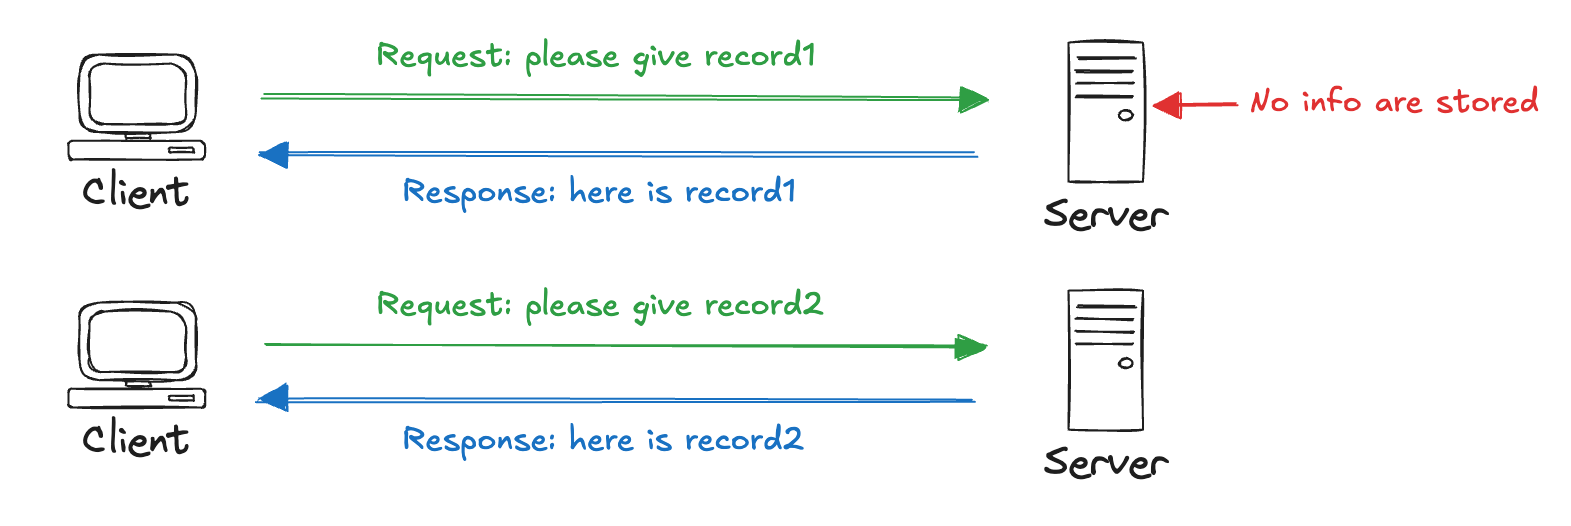

In contrast, a stateful server maintains session information. When the client requests a record, the server notes that the client is currently at this position. Later, if the client asks for the "next record", the server uses the stored context to infer the next record. This approach requires the server to store client-specific state, tying the logic of future responses to past interactions:

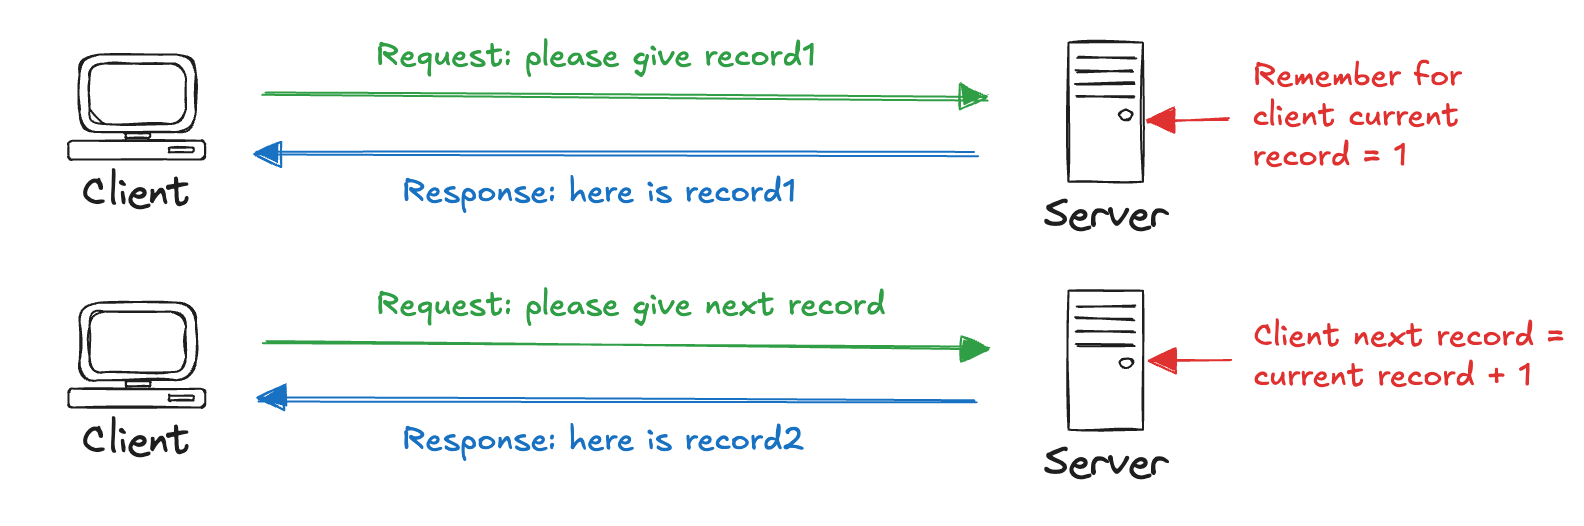


It is important to note that the stateless constraint **does not prohibit applications or servers from managing state** internally. Rather, it requires that all necessary state be conveyed explicitly in the interactions between components. For example, a web application may allow users to build a shopping cart over time. Even in a stateless RESTful system, this cart can be maintained by the client and sent with each request.

Stateless communication also facilitates other design features. Authentication mechanisms, for instance, often use stateless tokens that include encoded claims about the user's identity and permissions. **Pagination** schemes can be implemented by passing parameters or cursors that specify the desired subset of data. This way, the server does not need to remember where the client left off. Similarly, stateless systems are **more resilient to retry mechanisms**. Since each request contains all required information, it can be safely repeated in case of timeout or failure.

In summary, the stateless constraint enables clean, scalable, and robust interactions in distributed systems. By ensuring that each request is self-contained, statelessness reduces dependencies between client and server, enhances system transparency, and simplifies recovery and scaling strategies. It is a core feature that underpins the success of RESTful architectures and the broader web ecosystem.

### Constraint 4: Cacheable

The cacheable allows responses from the server to be **explicitly marked as cacheable**, permitting clients and intermediaries such as proxies to store them locally and reuse them when appropriate. The idea behind caching is straightforward yet powerful: avoid redundant data transfers by reusing previously retrieved responses.

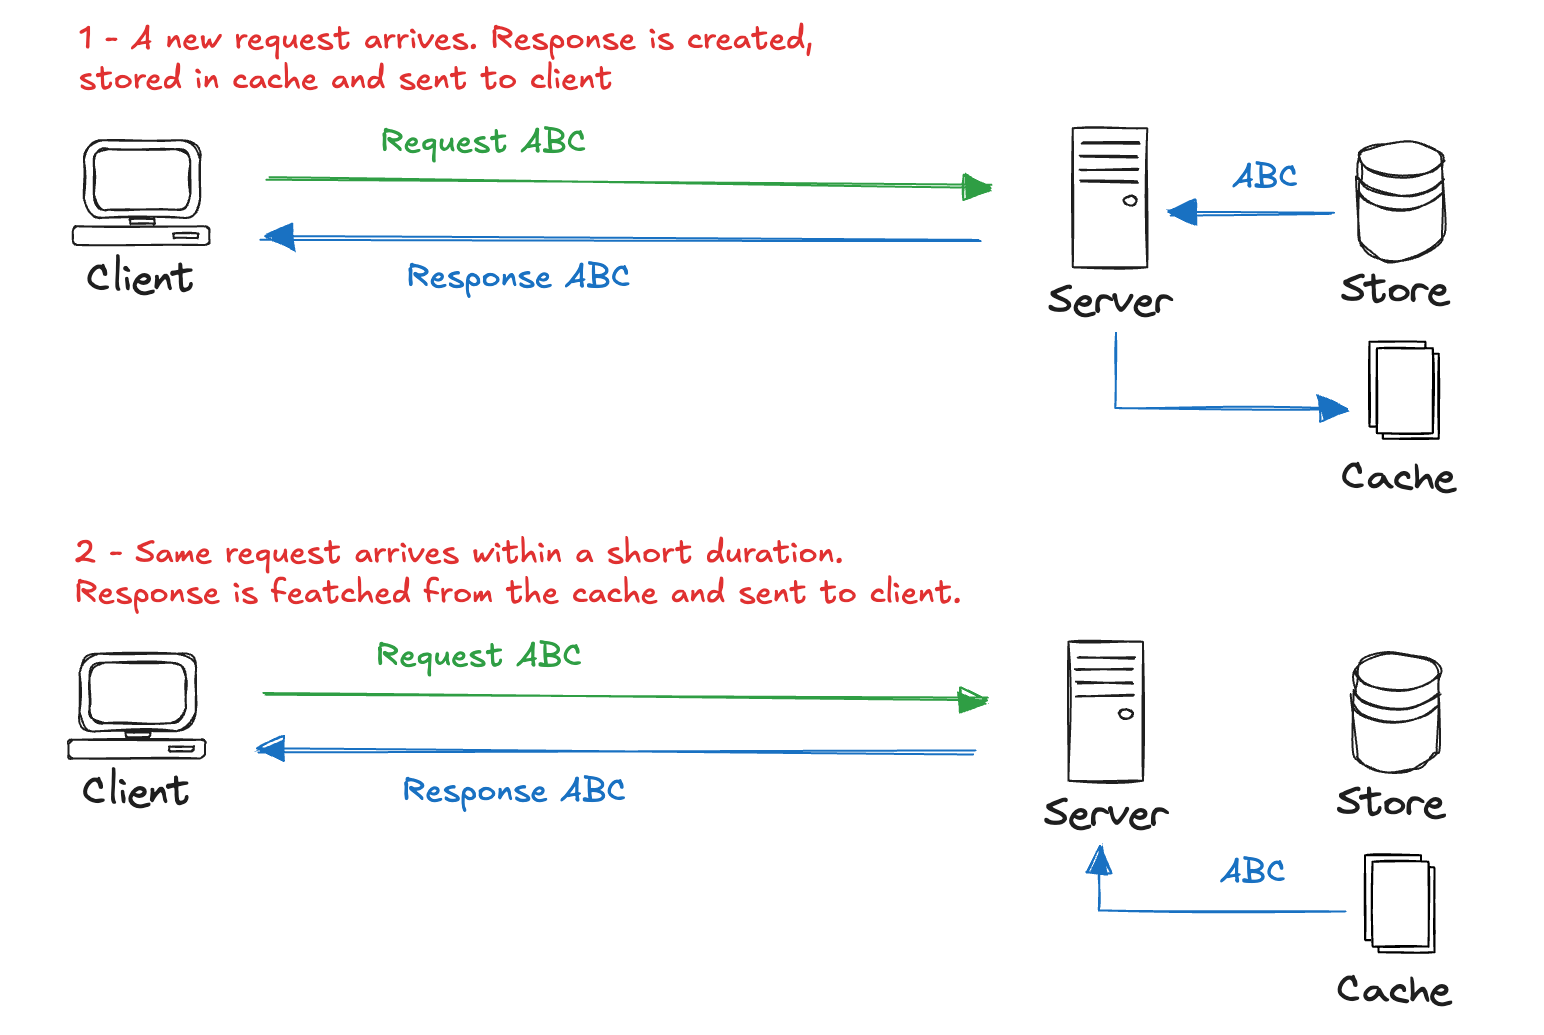

In a RESTful architecture, caching is treated as an **architectural feature, not just an implementation detail**. When a server responds to a client request, it can include metadata that instructs the client or an intermediary whether the response may be cached and under what conditions it can be reused. This metadata typically includes HTTP headers like Cache-Control, Expires, or entity tags like ETag. These headers define the rules that govern the lifetime of a cached response and the conditions under which it must be revalidated with the server.

Allowing clients and intermediaries to store data locally has immediate performance advantages. By serving repeated requests from a nearby cache rather than contacting the origin server, RESTful systems **reduce response time** and **conserve bandwidth**. This is particularly beneficial in high-latency environments or when dealing with mobile or embedded devices. Moreover, caching helps to **alleviate the load on backend servers**. When thousands of users request the same resource, serving them from distributed caches rather than repeatedly computing or retrieving the resource from a central point greatly improves system scalability and availability.

However, the benefits of caching must be balanced against the **risk of serving stale or outdated data**. To maintain data consistency, RESTful systems rely on **caching policies** that control how long data can be reused and when it must be refreshed. These policies can define expiration times or specify that a client must verify with the server whether the cached version is still valid. For instance, a client might send a conditional request using the If-Modified-Since or If-None-Match headers. If the resource has not changed, the server can return a lightweight 304 Not Modified response, thus saving resources and avoiding unnecessary data transfer.

The impact of the cacheable constraint is visible in several areas. From the user's perspective, **applications feel faster** because data is often retrieved from a local cache. From the server’s viewpoint, fewer incoming requests translate into **lower processing demands** and improved scalability. From a network perspective, reduced traffic l**owers the chance of congestion** and improves overall efficiency.

Caching is particularly important in the design of modern web applications and distributed systems. It underpins technologies such as **content delivery networks**, which replicate popular resources across geographically distributed caches, and browser caches, which store static assets like images, scripts, or style sheets locally. In RESTful systems, the cacheable constraint extends this principle to dynamic data and API responses, contributing to a better, faster, and more reliable user experience.

In conclusion, the cacheable constraint reinforces REST’s emphasis on statelessness, efficiency, and independence between components. By delegating the responsibility of reusing responses to clients and intermediaries, and by defining clear rules for freshness and invalidation, RESTful systems become more robust and performant. This constraint is a cornerstone of web architecture and remains a key factor in the scalability and success of the modern Internet.

### Constraint 5:  Layered System

The Layered System constraint refers to the architectural principle of **organizing system components into hierarchical layers**. Each layer serves a specific function and interacts only with its immediate neighbors, without needing to know the details of components beyond its adjacent layers. This approach promotes a **clean separation of concerns** and enhances the **modularity** of distributed systems.

One of the main advantages of the layered system is the ability to introduce intermediate components such as **proxies**, **gateways**, and **caches**, which act as mediators between clients and servers. These intermediaries can be used to improve performance, manage security, balance loads, or support legacy systems, all without changing the way clients interact with the system. From the client’s perspective, there is **no visible difference** between interacting with the final server and interacting with an intermediary. This abstraction makes the system more flexible and easier to evolve.

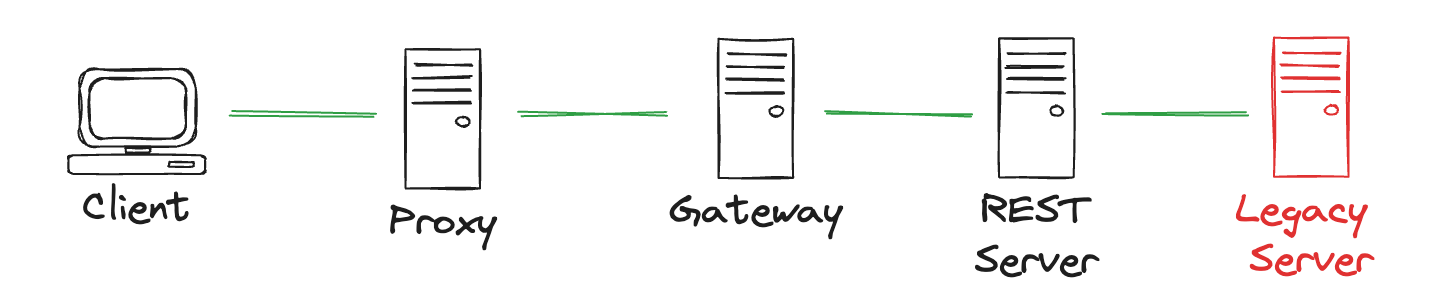


An illustrative example is the use of **distributed caches**. These caches can store frequently accessed data at various locations around the globe. When a client requests a resource, the request may be fulfilled by a nearby cache instead of the origin server, leading to faster response times and reduced load on the server infrastructure. The client does not need to know whether the data comes from the server or a cache; it only cares about receiving the correct response.

Another important application of the layered system is in **encapsulating legacy systems**. A RESTful interface can be placed in front of an older backend that uses proprietary or outdated communication protocols. This wrapper acts as a translator between the modern RESTful API and the legacy logic, allowing clients to interact with the old system through a standardized, web-friendly interface.

By enabling such abstractions, the layered system constraint makes it possible to build large, scalable applications in which components can be developed, deployed, and maintained independently. It also enhances security by allowing sensitive operations such as authentication or rate-limiting to be handled at intermediary layers, shielding backend servers from unnecessary complexity and potential threats.

In summary, the layered system constraint allows RESTful systems to be composed of modular, replaceable parts. It supports scalability by allowing load distribution, improves performance through mechanisms like caching, and ensures flexibility by enabling the integration of legacy technologies behind modern interfaces. This principle contributes significantly to the robustness and longevity of web architectures built according to REST.


### Comparison with SOAP

The Simple Object Access Protocol (SOAP) is a protocol developed  by Microsoft in 1998 to facilitate structured and reliable communication between distributed systems. At the time, the primary focus was on enabling RPC style communication over the Internet using XML, a format that was gaining traction for its ability to represent complex data in a human and machine readable way. 

SOAP operates primarily over HTTP but is **transport-neutral**, meaning it can also function over other protocols. SOAP messages are strictly formatted as XML documents and follow a specific structure composed of an envelope, a header, and a body. The body of the message contains the actual data or command to be executed, and the header may carry metadata such as authentication or transaction controls. SOAP was widely adopted in the early 2000s, particularly in enterprise systems, because of its ability to provide advanced features such as built-in security, transaction management, and formal interface definitions through WSDL (Web Services Description Language).

Despite these strengths, SOAP has gradually fallen out of favor for most web applications due to its **verbosity**, **rigidity**, and **high implementation complexity**. As web technologies evolved, developers began to seek lighter and more flexible alternatives for building web services. This shift led to the emergence of REST, since it does not define a protocol but rather a set of constraints that, when followed, enable scalable and loosely coupled systems. Instead of wrapping data in envelopes and using XML schemas as SOAP does, RESTful systems treat data as resources and exploit completely the HTTP semantic:

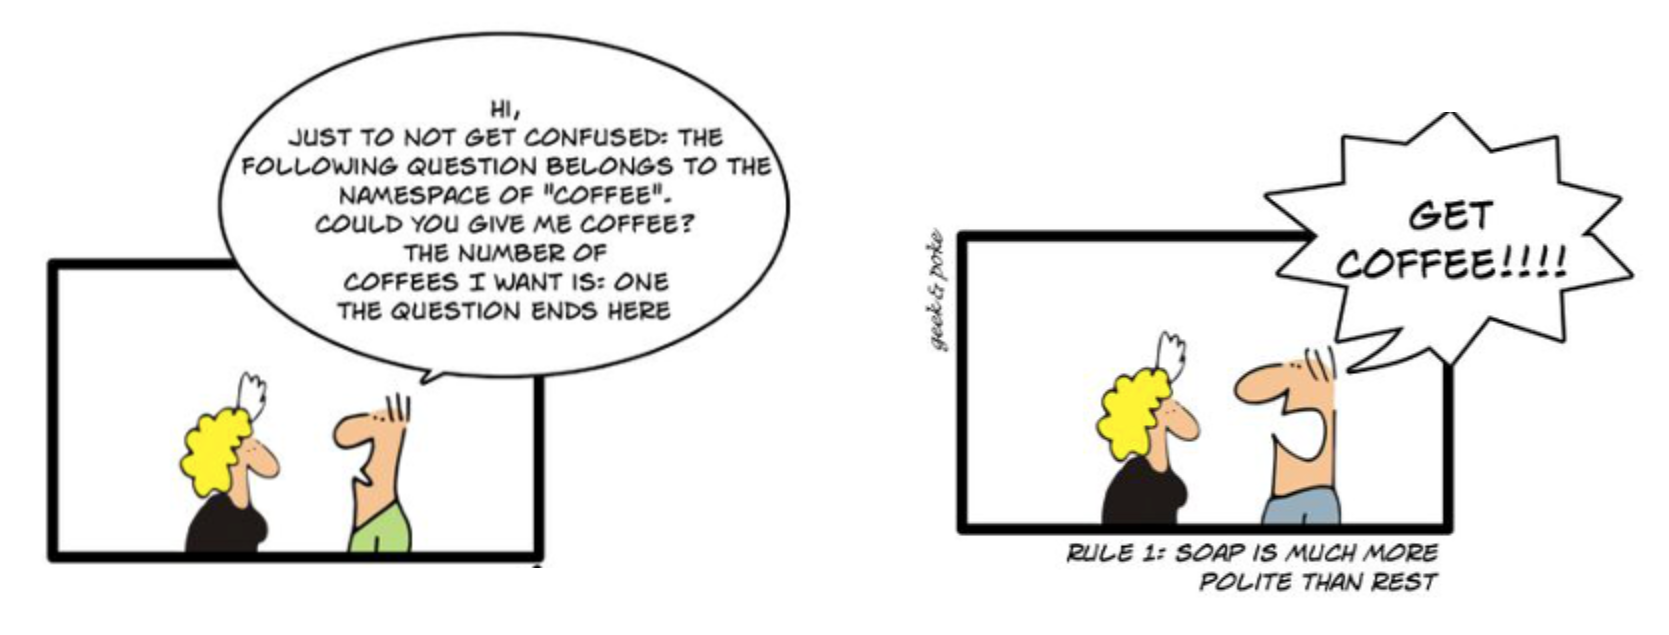

The major conceptual differences lies in **how each approach treats HTTP**. In SOAP systems, HTTP is simply a transport mechanism. The semantics of the operations are embedded within the SOAP body and understood through WSDL contracts. REST, on the other hand, embraces HTTP as its foundation, using its methods directly to express operations and relying on URI patterns to identify resources. This makes REST more aligned with the native architecture of the Web and simplifies development by eliminating the need for additional messaging protocols or service descriptions.

REST gained popularity throughout the 2000s, especially as companies like Amazon, Google, Twitter, and Facebook began offering web services that followed RESTful principles. Its simplicity, use of standard HTTP methods, and compatibility with JSON instead of XML made REST highly attractive for building web and mobile applications. Developers appreciated not having to generate WSDL documents or manage SOAP envelopes; instead, they could design APIs that were intuitive, fast, and directly accessible from any browser or HTTP client. The rise of smartphones and the proliferation of connected devices further accelerated the shift toward REST, as these environments required efficient data exchange and low-power communication models.

Today, while SOAP continues to be used in specific domains such as enterprise integration, financial transactions, and governmental systems, REST has become the dominant paradigm for API design. The historical shift from SOAP to REST reflects a broader evolution in software architecture: from rigid, standardized contracts designed for reliability to flexible, web-native systems optimized for speed, usability, and scalability.

## Resources

In RESTful architecture, the fundamental building block is the **resource**. A resource can be any piece of data or conceptual entity that an application manages: a sensor in a smart home or a user profile, a document, or even an abstract process. This abstraction shifts the development mindset away from traditional Remote Procedure Call (RPC) mechanisms toward an interaction model based on resources and representations.

RESTful systems treat everything (documents, images, users, sensors, services, or even abstract concepts) as resources. These resources are exposed via URIs and are manipulated using standard HTTP methods. This design promotes **loose coupling** between client and server components and leverages the existing infrastructure of the Web to build scalable, interoperable, and evolvable systems.

The design of those resources should follow a few principles: addressability, manipulation through representations, self descriptiveness, and hateoas.

### Principle 1: Addressable Resources

A resource is an **abstraction** that represents a piece of information or capability. It is not the data itself, but rather a conceptual mapping to a set of entities or services. For example, a temperature sensor does not expose its internal state directly, but instead provides an interface to retrieve a current temperature reading or configure settings. The principle of Addressable Resources asserts that each of these entities must be **uniquely identifiable** and **accessible** via a **Uniform Resource Identifier** (URI). This principle is foundational in enabling scalable, discoverable, and interoperable web services.

The structure of a URI adheres to a general syntax:

In [ ]:
`<scheme> ":" <authority><path> [ "?" query ] [ "#" fragment ]`

This structure allows for hierarchical organization and scoping of resources. For example:

* http://gateway.api.com/devices/TV/ identifies a television device.
* https://kitchen:3000/fridge/ points to a fridge in a kitchen-based local server.

In the context of the Web of Things (WoT), every device must have a root URL that corresponds to its network location. These URLs are not arbitrary; they should reflect the logical structure and relationships of the physical or virtual entities they represent.

Resources are often structured hierarchically using path segments. This allows developers to model relationships, containment, or grouping:

* http://devices.webofthings.io/24/sensors might represent all sensors on device ID 24.
* http://192.168.44.12/building4/devices/ could list all devices within a specific building.

The hierarchy encoded in the URI can reveal **spatial**, **organizational**, or **functional relationships** among Things, which is particularly relevant in IoT environments.

While there are no strict rules governing the semantics of resource identifiers, several **best practices** help make APIs more intuitive and maintainable:

- **Use Descriptive Names**: choose terms that carry semantic meaning to humans, improving readability and usability. For instance, /temperature, /sensors, or /status is much more understandable than vague identifiers like /a1b2c3.

- **Avoid Verbs in URIs**: URIs should name resources, **not actions**. Actions are communicated through HTTP methods. For example:

   - Bad: /garagedoor/openDoor
   - Good: /garagedoor/status, the GET method retrieves the status, and a PUT may change it.

- **Use Plurals for Collections**: when referring to a collection or aggregate of similar resources, the plural form should be used:
   
   - /sensors for a collection of sensor entities
   - /students for a list of student resources

These conventions ensure consistency and aid both human and machine consumers in interpreting API semantics effectively.


### Principle 2: Manipulation through Representations

A resource is an abstract concept, it is not a physical object or data file, but a virtual entity that represents some information or functionality within the system. What clients interact with are not the resources themselves, but rather their **representations**. A representation is **a concrete and tangible instance of a resource's state** at a given time, **encoded in a particular format** suitable for transmission over a network.

These representations are standardized using **media types**, more commonly known as MIME types. MIME types describe how a resource is formatted and enable clients and servers to correctly interpret the data being exchanged. For example, an image encoded in PNG format is labeled as "image/png", and an audio file in MP3 format is labeled as "audio/mp3". The complete list of official MIME types is maintained by the Internet Assigned Numbers Authority (IANA), ensuring consistency and reliability across different platforms and implementations.

RESTful systems take advantage of HTTP **content negotiation mechanism** to determine the most appropriate representation format for a given request. A client can specify its preferred formats using HTTP headers such as "Accept", and the server will respond with the best available representation that meets those preferences. This mechanism increases flexibility by allowing the same resource to be available in multiple formats, depending on the needs of the client and the capabilities of the server.

In the context of the Web of Things, the selection of a representation format becomes even more critical due to constraints such as limited memory, low processing power, and battery efficiency. Currently, JSON is the most widely adopted format, since it is lightweight, portable, self-contained, and easy to parse, making it ideal for constrained environments. However, because it is still a text-based format, it may not be optimal for devices that require more compact data transmissions.

To address this, alternative formats such as [**MessagePack**](https://msgpack.org/) have been proposed. MessagePack is a **binary serialization format** that retains the structure and semantics of JSON while providing a smaller and faster encoding. It is recently an officially recognized MIME type (2024) and it shows promise for scenarios where bandwidth and storage are critical concerns.

Best practices in RESTful WoT systems dictate that all devices and services must support **JSON as the default representation format** to ensure baseline compatibility. Additionally, they **may offer HTML-based representations, particularly when a human interface is required**, such as in dashboards or configuration panels.

Ultimately, the concept of representations reinforces the separation between the abstract nature of resources and their concrete instances.

### Principle 3: Self-descriptiveness

Each message exchanged between client and server should be self-descriptive. This means that the message must contain all the information necessary to understand and correctly process the request or the response, without relying on prior knowledge or out-of-band information. By embedding meaning into the message itself (through standardized structures, metadata, and semantics) REST promotes interoperability, reliability, and the evolution of distributed systems.

In practical terms, self-descriptive messages in REST rely on the use of standard HTTP methods (GET, POST, PUT, DELETE) each with **well-defined semantics**. These correspond to the **basic CRUD operations**: Create, Read, Update, and Delete. By adopting these verbs consistently, systems can expose predictable interfaces, enabling clients to interact with resources without knowing implementation details. This design significantly contributes to **loose coupling**: clients only need to understand and support the semantics of these operations, and not how a server internally manages its state or resources.

This principle maps particularly well to the Web of Things, where devices usually expose simple, atomic functionalities. For instance, a sensor might provide its current value via a GET request, while an actuator like a smart bulb may be controlled through a PUT request that modifies its state. Because devices are limited in capability and often operate in constrained environments, the predictability and simplicity of self-descriptive messages are crucial for achieving interoperability and ease of integration.

HTTP **status codes** are another key aspect of this principle. These codes (such as 200 OK, 404 Not Found, 500 Internal Server Error) provide a lightweight and standardized mechanism to inform clients about the outcome of their requests. Clients can **understand the result of an operation without any prior agreement** with the server, thus enhancing visibility and error handling in distributed applications.

To ensure that RESTful systems respect this principle, a number of guidelines should be followed:

- Every device or service must support the core HTTP verbs in a way consistent with their semantics. For example, a GET on a sensor returns its reading, a POST might create a new configuration or rule, a PUT updates an existing resource, and DELETE removes it.
- HTTP status codes must be implemented correctly, covering both success (2xx series) and various error conditions (4xx and 5xx series).
- Devices must support a GET request on their root URL, so that clients can always obtain metadata or descriptive information about the resource.

By making every message self-contained and understandable in isolation, REST enables scalable, distributed systems that are easier to evolve and debug. This principle is not just about adhering to HTTP standards, it is about designing messages and interfaces that are **explicit**, transparent, and robust in the face of the heterogeneity and dynamism typical of web-scale systems.

### Principle 4: HATEOAS

Hypermedia as the Engine of Application State (HATEOAS) ensures that clients interact with a REST API dynamically through **hyperlinks** embedded in the resource representations, without requiring out-of-band information or hardcoded workflows. This principle transforms the interaction between clients and servers into a discoverable, navigable experience, like to browsing the human-readable Web.

At the heart of HATEOAS lie two key ideas: 

- **Hypermedia** refers to the use of links (and sometimes forms or embedded controls) within the representations of resources to indicate potential actions or navigational paths. These links guide the client through available operations and transitions without needing prior knowledge of the API’s structure. 
- **Application state** refers to a step in a process or workflow in which the client resides, the set of available links reflects the current state and the valid next steps.

To implement HATEOAS effectively, **every possible application state is treated as a RESTful resource** with its own unique URI. For instance, the current state of a smart device (like the color or status of an LED) can be accessed through a specific URL. A client can retrieve a JSON representation of that state, which also includes links to other operations: such as turning the LED on or off, changing its brightness, or querying related sensors. These navigational affordances are crucial in both human-driven interactions and machine-driven automation.

An essential characteristic of HATEOAS is that it decouples clients from the internal logic of the server. The client does not need to know in advance which URIs to invoke for future steps, it simply follows the links provided in the current response. This means that **the server fully controls the application flow and exposes possible transitions**, dynamically adapting the API surface depending on context. For example, suppose to querying a bank account resource:

In [ ]:
GET /accounts/12345 HTTP/1.1
Host: api.example.com

The server might return different follow-up links depending on the account balance: an account with positive balance might offer options to withdraw, deposit, or close the account:

In [ ]:
{
    "account": {
        "account_number": 12345,
        "balance": {
            "amount": 1000.00,
            "currency": "USD"
        },
        "links": {
            "deposit": {
                "href": "/accounts/12345/deposits",
                "method": "POST"
            },
            "withdraw": {
                "href": "/accounts/12345/withdrawals",
                "method": "POST"
            },
            "transfer": {
                "href": "/accounts/12345/transfers",
                "method": "POST"
            }
        }
    }
}

whereas an overdrawn account might only allow deposits:

In [ ]:
{
    "account": {
        "account_number": 12345,
        "balance": {
            "amount": -25.00,
            "currency": "USD"
        },
        "links": {
            "deposit": {
                "href": "/accounts/12345/deposits",
                "method": "POST"
            }
        }
    }
}

This **dynamic discovery model** is especially relevant for the Web of Things. In WoT systems, devices often change their capabilities or available operations over time. With HATEOAS, clients can discover related resources (such as actuators, rules, or sensor readings) without relying on a fixed sitemap. Human users can browse resources intuitively, while machine clients can crawl or traverse them programmatically, enabling scalable automation and dynamic reconfiguration of IoT environments.

Ultimately, HATEOAS embodies the Web’s ethos of **navigation by exploration**. By embedding state-transition logic within resource representations, it creates **self-documenting APIs** that naturally evolve. Clients can interact with them without version-specific manuals, hardcoded paths, or brittle assumptions: just by following the links. In this way, HATEOAS not only enhances loose coupling and resilience, but also makes RESTful APIs more flexible, extensible, and aligned with the distributed nature of the Web itself.

## Richardson Maturity Model

The Richardson Maturity Model is a conceptual framework that evaluates the maturity of a web service's RESTful design. Proposed by Leonard Richardson, it breaks down the journey toward achieving a **fully RESTful architecture** into four progressive levels. Each level introduces a deeper commitment to the REST architectural style and brings the implementation closer to what is often called the "Glory of REST".

### Level 0: The Swamp of POX

At the base of the model lies Level 0, sometimes pejoratively described as the "Swamp of POX" (Plain Old XML). This level represents systems that **use HTTP merely as a transport mechanism for remote procedure calls (RPC)**, with no regard for RESTful principles. The interface typically consists of **a single URI** that serves as an entry point for all operations, and **HTTP methods are often ignored** in favor of tunneling every interaction through POST. This approach negates the semantics of HTTP, often ignoring its native capabilities like caching, content negotiation, and status codes. Systems at this level are tightly coupled and hard to scale or evolve independently.

As a running example, we consider a simple web service that allows users to get an appointment from a doctor. In a level 0 implementation, the service exposes a single endpoint, such as /appointmentService, and all operations are performed using POST requests. The request body contains XML or JSON data that specifies the action to be taken (e.g., "getAppointment", "cancelAppointment"). The server processes the request and returns a response, but the client has no way of knowing what operations are available or how to interact with the service beyond the initial POST:

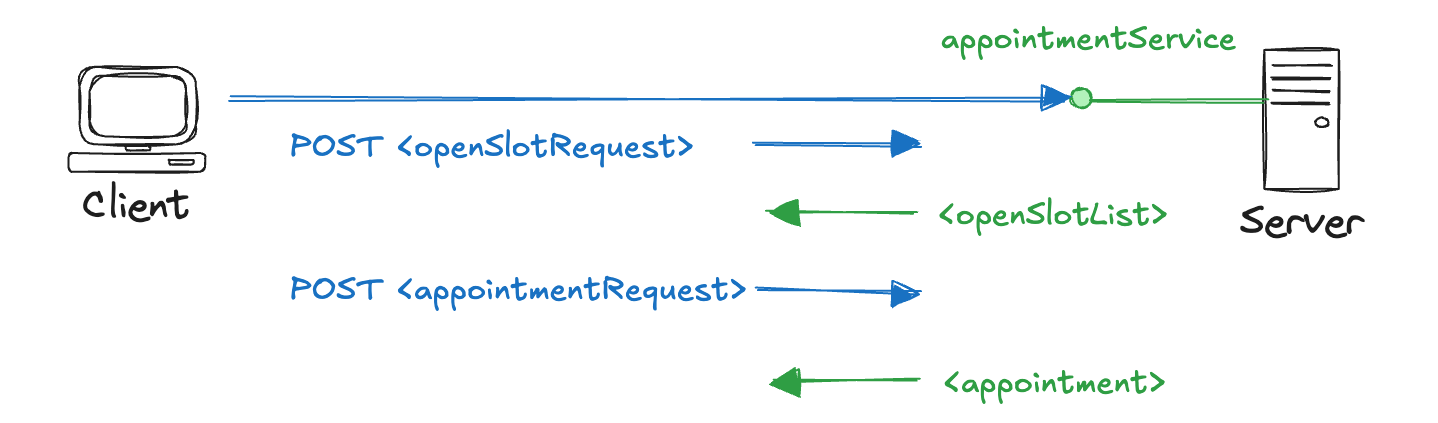

Here a simple implementation of a level 0 service in Node.js (see 02.level0/server.js code):

In [ ]:
const express = require('express');
const app = express();

app.use(express.json());

// Simulated database
const openSlots = [
  { id: 1, time: "2025-05-12T10:00:00" },
  { id: 2, time: "2025-05-12T11:00:00" }
];

// Simulated appointment storage
const appointments = [];

// RPC-like API for appointment service
app.post('/appointmentService', (req, res) => {

  const { method, payload } = req.body;

  // Retrieve available slots
  if (method === 'openSlotRequest') {
    res.json({ openSlotList: openSlots });
  } 

  // Handle appointment requests
  else if (method === 'appointmentRequest') {
    const { slotId, user } = payload;

    const slot = openSlots.find(s => s.id === slotId);
    if (!slot) { return res.status(400).json({ error: "Slot not available" }); }

    // Simulate appointment creation
    const appointment = {
      id: appointments.length + 1,
      slot,
      user
    };

    // Add appointment to storage
    appointments.push(appointment);

    // Reply with appointment details
    res.json({ appointment });
  } 
  
  // Handle unknown methods
  else { res.status(400).json({ error: 'Unknown method' });}
});

// Start the appointment service server
app.listen(3000, () => {console.log('Level 0 RPC API running on http://localhost:3000'); });

And here is a simple client that consumes the service:

In [ ]:
POST http://localhost:3000/appointmentService
Content-Type: application/json
{
  "method": "openSlotRequest",
  "payload": {}
}

POST http://localhost:3000/appointmentService
Content-Type: application/json
{
  "method": "appointmentRequest",
  "payload": {
    "slotId": 1,
    "user": "Alice"
  }
}

The Level 0 is limited. All interactions are funneled through a single endpoint, typically using the POST method, regardless of the nature of the operation. This means that even simple read operations, such as retrieving a list of available appointment slots, are treated the same way as state-changing operations like creating an appointment. As a result, the **API does not benefit from HTTP's semantics**, such as using GET for safe, idempotent reads, or DELETE for resource removal.

Additionally, the approach **lacks resource orientation**. Instead of exposing identifiable resources like /appointments/123, it hides the underlying domain behind abstract method calls such as "appointmentRequest", which must be known and understood in advance by the client. This **tight coupling** between client and server **reduces the discoverability and evolvability of the API**. Clients cannot easily understand or adapt to new functionality without prior knowledge, and the messages are not self-descriptive.

The absence of distinct URIs also means the system **cannot leverage the benefits of HTTP features such as caching, conditional requests, and proper status codes**. Intermediaries like proxies or CDNs are less effective, and observability suffers because logging, monitoring, and debugging are more difficult when every action passes through the same generic endpoint.

Ultimately, this RPC-style API design sacrifices scalability, flexibility, and long-term maintainability for the convenience of a simplistic interface, making it harder to extend or integrate in complex, distributed environments.

### Level 1: Resources

Level 1 introduces the concept of **resources**. Rather than exposing a single service endpoint, the system starts organizing its capabilities around uniquely identifiable resources, each with its own URI. This decomposition helps tackle complexity by enabling a divide-and-conquer strategy: instead of one monolithic service, the API is structured as a set of addressable entities. For example, /students, /courses, and /grades become distinct endpoints. While this level brings clarity and a modular structure to the API, it still often relies on a single HTTP verb like POST for all operations, which limits its RESTfulness. We can modify the previous example to use resources:

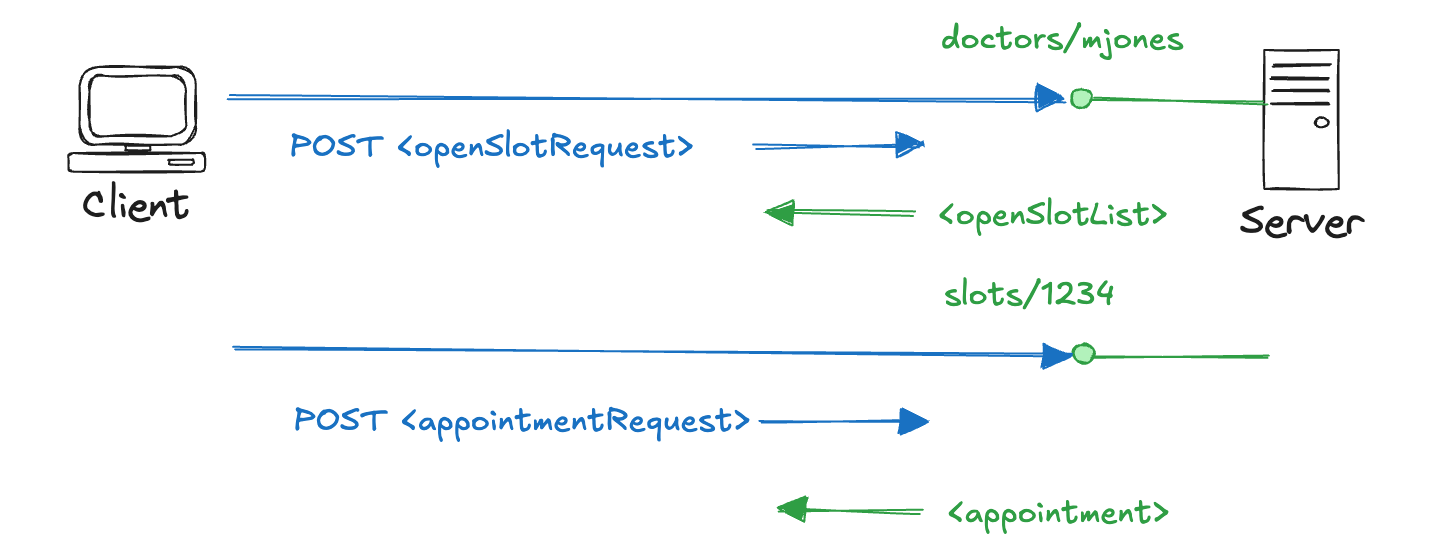

Here the modified server code (see 03.level1/server.js code):

In [ ]:
// A resource for each doctor
app.post('/doctors/:doctorId', (req, res) => {
  const doctorId = req.params.doctorId;
  const slots = openSlots[doctorId] || [];
  return res.json({ openSlotList: slots });
});

// A resource for each slot
app.post('/slots/:slotId', (req, res) => {
  const slotId = parseInt(req.params.slotId);
  const user = req.body.user;
  const slot = Object.values(openSlots).flat().find(s => s.id === slotId);
  if (!slot) { return res.status(404).json({ error: "Slot not found" }); }

  const appointment = {
    id: appointments.length + 1,
    slot,
    user
  };

  appointments.push(appointment);
  return res.json({ appointment });
});

The improvement from Level 0 to Level 1 lies in i**ntroducing resource-specific URIs**, allowing the API to identify and target individual entities like doctors or slots, rather than routing all actions through a single generic endpoint. Now the client can interact with the API using URIs:

In [ ]:
POST http://localhost:3000/doctors/1
Content-Type: application/json
{}

POST http://localhost:3000/slots/2
Content-Type: application/json
{
  "user": "Alice"
}

### Level 2: HTTP Verbs

At Level 2, the service begins to **fully embrace the semantics of HTTP** by using its standard verbs (GET, POST, PUT, DELETE) appropriately across resources. These verbs correspond naturally to CRUD operations (Create, Read, Update, Delete). A GET request retrieves a resource, POST creates a new one, PUT updates an existing resource, and DELETE removes it. This approach standardizes interaction patterns, eliminates unnecessary variation, and enables clients to operate with predictable behaviors. Level 2 significantly improves scalability, interoperability, and ease of use because it adheres to well-known web standards. The example can be modified to use the HTTP verbs:

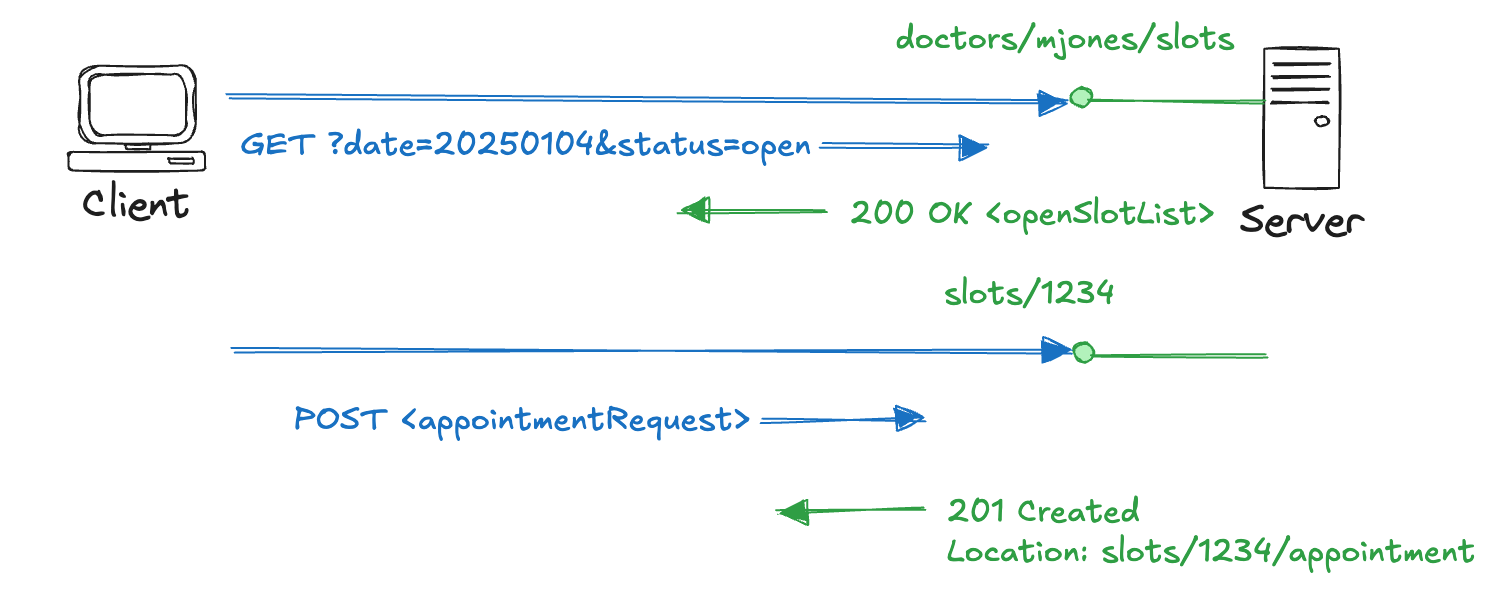

Here the modified server code (see 04.level2/server.js code):

In [ ]:
// The slots for a doctor using GET
app.get('/doctors/:doctorId/slots', (req, res) => {
  const { doctorId } = req.params;
  const slots = openSlots[doctorId] 
  res.status(200).json({ openSlotList: slots });
});

The improvement from Level 1 to Level 2 lies in the proper use of HTTP methods to express the semantics of operations. While Level 1 introduced resource-oriented URIs, it still relied exclusively on POST for all actions, treating every operation as a remote procedure. In contrast, Level 2 aligns with RESTful principles by using different HTTP verbs, such as GET for retrieving data and POST for creating new resources, making the API more expressive, predictable, and aligned with standard web architecture. Now the client can interact with the API using the appropriate HTTP methods:

In [ ]:
GET http://localhost:3000/doctors/1/slots
Accept: application/json

POST http://localhost:3000/slots/1
Content-Type: application/json
{
  "user": "Alice"
}

This shift improves clarity for clients, who can now infer the nature of the operation from the HTTP verb itself, and enables better support for HTTP features like caching, idempotency, and status code conventions. Filtering through query parameters becomes more natural and standardized, enhancing the discoverability of resources. Additionally, responses can now include meaningful status codes (e.g., 200 OK, 201 Created) and headers like Location, helping clients understand the outcome of their requests without relying solely on custom response formats.

### Level 3: Hypermedia Controls (HATEOAS)

The final level, Level 3, introduces **Hypermedia as the Engine of Application State** (HATEOAS), a cornerstone of REST as defined by Roy Fielding. Here, the server provides not only the data but also the **available actions** a client can take next, in the form of hyperlinks embedded in the response. These hypermedia controls guide clients through the application workflow without relying on out-of-band knowledge. This means clients can **dynamically discover** the API’s capabilities by following links rather than hardcoding endpoint URIs and expected actions. This level supports better decoupling, adaptability, and resilience to change. It also improves the API's discoverability, making it more self-documenting. The example can be modified to use hypermedia controls:

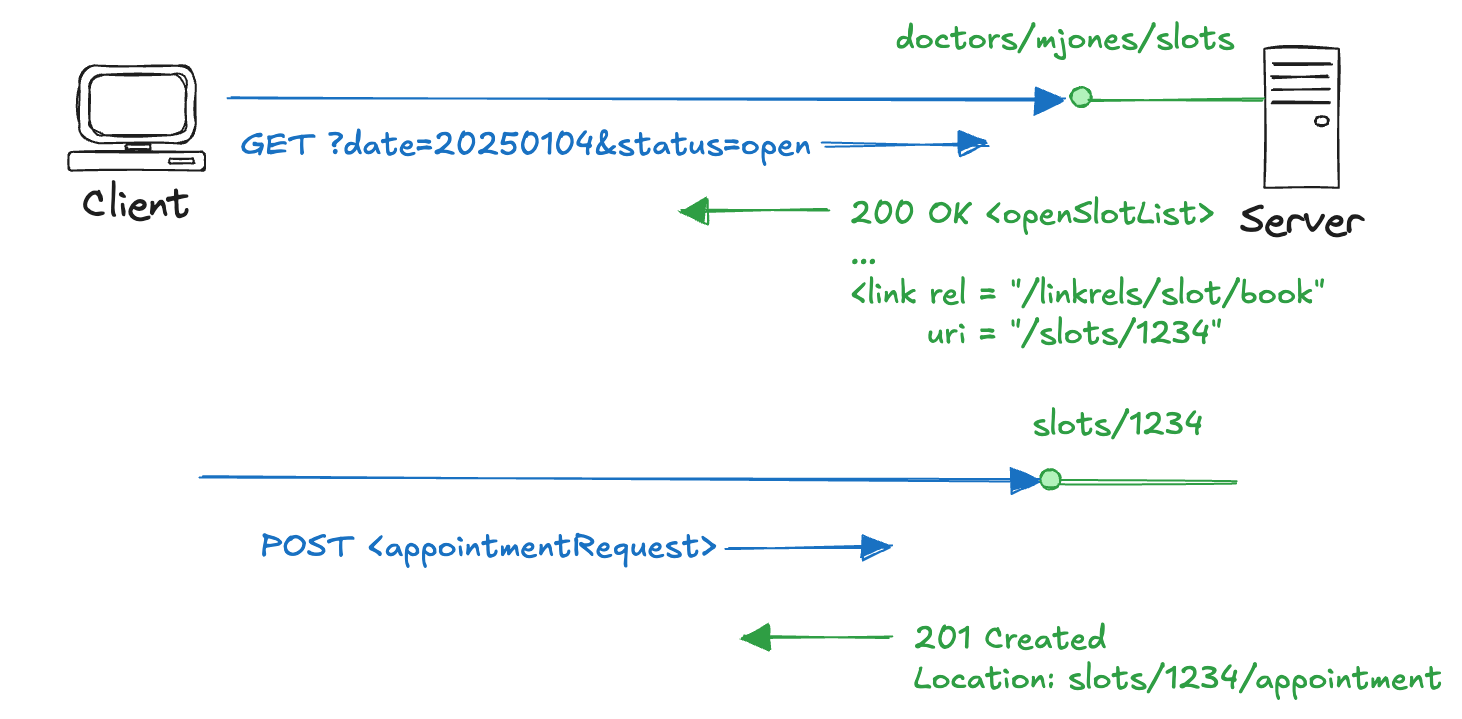

Here the modified server code (see 05.level3/server.js code):

In [ ]:
app.get('/doctors/:doctorId/slots', (req, res) => {
  const { doctorId } = req.params;
  const slots = openSlots[doctorId]

  const enrichedSlots = slots.map(slot => ({
    id: slot.id,
    time: slot.time,
    _links: {
      book: {
        href: `/slots/${slot.id}`,
        rel: "Make appointment",
        method: "POST"
      }
    }
  }));

  res.status(200).json({ openSlotList: enrichedSlots });
});

The improvement from Level 2 to Level 3 lies in the introduction of hypermedia controls, which make the API truly RESTful by enabling clients to navigate the application dynamically through links provided in the server’s responses. While Level 2 uses proper HTTP verbs and resource-oriented URIs, it still requires clients to hardcode knowledge of those URIs and workflows. With Level 3, the server guides the client by embedding links that describe available actions, such as how to book an appointment for a slot. This decouples the client from the internal URI structure and allows the API to evolve more easily, since clients follow links rather than constructing paths manually. It also improves discoverability, self-documentation, and flexibility, as each resource response includes affordances for the next available operations, making interactions more intuitive and state-driven.

### The Glory of REST

Summarizing the Richardson Maturity Model, REST offers a powerful architectural style for building scalable and maintainable web services. Its strength lies in a layered approach to simplifying complexity and improving interoperability.

- At **Level 1**, REST addresses complexity through **divide and conquer**: a large service endpoint is broken down into multiple distinct resources. This separation allows developers to manage and understand the system more easily by isolating concerns and structuring the API around meaningful entities.

- **Level 2** advances this structure by introducing a standard set of HTTP verbs (such as GET, POST, PUT, DELETE), enabling the system to **handle similar situations in the same way**. This reduces variability, encourages consistency, and simplifies client-server interactions by applying a uniform interface to all resources.

- **Level 3** brings in the concept of **discoverability** through hypermedia. By embedding links and actions within responses, RESTful systems become **self-documenting**, guiding clients through available operations without requiring external documentation. 

Finally, REST realizes the Web’s original vision by treating HTTP not merely as a transport mechanism but **as an application layer protocol**. It allows the creation of APIs for Things (e.g., IoT devices) by reusing the proven architecture of the Web, integrating them as first-class citizens within the existing Web ecosystem.

## Real-World Examples

Understanding REST architecture in theory is essential, but examining how it is applied in real-world APIs is what truly brings its principles to life. We explore three widely-used web APIs to illustrate how REST constraints and best practices are adopted in practical implementations.

Each of these APIs serves a different domain: **Twitter (now X)** manages social interactions and user-generated content, **eBay** provides access to online marketplaces, and **PayPal** supports secure payment and billing operations. Despite their differing scopes and technical histories, all three APIs expose HTTP-based interfaces that allow developers to interact with their underlying services in a structured, programmatic way.

By analyzing these APIs, we highlight the diversity of REST implementations in the wild and reveal the spectrum between partial and full adoption of the REST architectural style. These examples help clarify what it means for an API to be **RESTful** in practice and what trade-offs different providers make between strict adherence to REST and practical integration needs.

### The X (Twitter) API

The X API (formerly Twitter API) is a compelling and instructive example of a RESTful API implemented at scale. It demonstrates how the REST architectural style can support a high-performance, distributed, and developer-friendly communication interface for a global social media platform. By exposing resources such as tweets, users, likes, and followers via clearly structured URIs and standard HTTP methods, X API embodies the foundational REST constraints and principles:

https://docs.x.com/x-api/introduction#x-api-v2

At its core, the X API is organized around addressable resources. Each tweet, user, or list is treated as a uniquely identifiable resource, which can be accessed through a stable and descriptive URL. For example, the endpoint:

In [ ]:
https://api.x.com/2/tweets?ids=1234567890

allows clients to retrieve the representation of a specific tweet. This aligns directly with the REST principle of addressable Resources, where each resource must have a unique identifier, often implemented using a URI. Representations of these resources are returned in JSON, including fields like id, text, lang, author or embedded user objects, which are representations of associated resources: 

In [ ]:
{
    "id": "1212092628029698048",
    "text": "This is the tweet text",
    "edit_history_tweet_ids": [
      "1212092628029698048"
    ],
    "author_id": "2244994945",
    "lang": "en",
    "in_reply_to_user_id": "2244994945",
    "public_metrics": {
      "retweet_count": 7,
      "reply_count": 3,
      "like_count": 38,
      "quote_count": 1
    },

    "created_at": "2019-12-31T19:26:16.000Z",
    "attachments": {
      "media_keys": [
        "16_1211797899316740096"
      ]
    },
    "possibly_sensitive": false,
    ...
}

The X API  makes use of standard HTTP verbs to implement actions over resources, illustrating the principle of self-descriptive messages. This facilitates loose coupling between client and server: developers can interact with the API by understanding the semantics of HTTP without needing to know the server's internal structure.

Although the current version of the X API (v2) partially implements hypermedia controls, the HATEOAS constraint is not fully embraced. While responses occasionally include embedded links and resource identifiers that facilitate discoverability, the API does not yet provide dynamic navigation of state transitions. This means that while the API is rich and consistent, clients still need to have prior knowledge of endpoint structures and workflows, rather than discovering them at runtime.

### eBay API

The **eBay Trading API** in the XML-based version as found at 

https://developer.ebay.com/Devzone/XML/docs/Reference/eBay/index.html

is not a good example of a RESTful API. It exemplifies a more traditional RPC-style architecture over HTTP, which falls under Level 0 of the Richardson Maturity Model. Instead of exposing addressable resources with URIs, the API relies on a single endpoint:

https://api.ebay.com/ws/api.dll 

and invokes different actions via XML payloads that include a call name to tunneling remote procedure calls through HTTP. There are no meaningful or descriptive URIs representing resources. Everything is addressed by the same base URL, violating the principle of addressable Resources in REST. All operations, whether reading, creating, or deleting data, are sent via POST. The HTTP method does not reflect the semantic meaning of the operation, which breaks the self-descriptive Messages principle. Instead of using standard HTTP methods to convey intent, it uses internal call names like AddItem, GetItem, EndItem, encoded in the body. This is a classic sign of RPC, not REST. While not disqualifying per se, the use of large XML schemas and SOAP-like semantics adds verbosity and complexity. Finally, there are no links or affordances in the response payloads to guide the client to next available actions or resources, meaning it lacks hypermedia controls entirely.

Instead, ehe **eBay Buy Browse API**:

https://developer.ebay.com/api-docs/buy/browse/resources/item_summary/methods/search

is a significant departure from the older XML-based Trading API, and it aligns much more closely with REST principles. The Buy Browse API is a Level 2 RESTful API (and nearly Level 3), using proper resource URIs and HTTP verbs, and returning JSON. It reflects a clear effort by eBay to adopt modern RESTful design and improve developer experience.

### PayPal API

The PayPal API, as documented at 

https://developer.paypal.com/docs/api/](https://developer.paypal.com/docs/api/

provides a robust and modern implementation of REST principles. Designed to handle a wide range of payment-related operations (including orders, payments, subscriptions, and identity verification) the API exemplifies a well-structured, secure, and developer-friendly RESTful service. It serves as a valuable real-world case study of how REST can be applied to a complex, security-critical domain like online payments.

Rather than exposing actions or procedures, the API defines addressable entities such as 

In [ ]:
/v2/checkout/orders 

/v1/payments/payment 

/v1/billing/plans 

Each URI uniquely identifies a specific resource and reflects its place in the hierarchy of the system, fulfilling the REST constraint of addressable resources. For instance, the URL 

https://api.paypal.com/v2/checkout/orders/5O190127TN364715T 

identifies a specific order and allows it to be retrieved, updated, or captured using the corresponding HTTP verbs. Furthermore, responses include standard HTTP status codes, which support clear and consistent error handling across client applications. The representation format used is exclusively JSON, allowing for compact, machine-readable payloads that can easily be parsed by a wide range of client applications.  Another strength of the PayPal API is its implementation of HATEOAS: each response includes a links array that details available next actions. This makes the API more discoverable, as clients can dynamically adapt to the workflow by following links rather than hardcoding endpoint logic. For example, after creating a payment order, the client receives a link that directs the user to approve the payment in their browser. Once approved, another link allows the server to capture the payment. Finally, PayPal provides **sandbox environments**, detailed **OpenAPI-based documentation**, and interactive examples that guide developers through common workflows. This contributes to a strong developer experience and encourages best practices for secure API integration. The PayPal REST API is a mature and well-engineered example of a level 3 RESTful API according to the Richardson Maturity Model. 

### Comparison

A comparative table that evaluates the **Twitter (X)**, **eBay**, and **PayPal** APIs against the key **REST constraints** and the **Richardson Maturity Model levels**:

| **REST Principle / Feature**      | **Twitter (X API v2)**                            | **eBay Trading API (XML)**              | **eBay Buy Browse API**          | **PayPal REST API**                       |
| --------------------------------- | ------------------------------------------------- | --------------------------------------- | -------------------------------- | ----------------------------------------- |
| **Resource-Oriented URIs**        | Yes – /2/users/:id, /2/tweets/:id                 | No – Single endpoint, action in body    | Yes – /item_summary/search       | Yes – /v2/checkout/orders                 |
| **HTTP Methods Used Properly**    | Yes – GET, POST, DELETE                           | No – Only POST used for all actions     | Yes – GET for search             | Yes – GET, POST, PATCH, DELETE            |
| **Standard Representations**      | JSON (compact and standard)                       | XML (heavy, legacy)                     | JSON                             | JSON with content negotiation             |
| **Stateless Interactions**        | Yes – Each request includes all context           | Nominally stateless, but RPC-like       | Yes                              | Yes                                       |
| **Self-descriptive Messages**     | Uses HTTP methods and status codes                | Custom call names in XML payload        | Clear use of methods and codes   | Rich status codes and headers             |
| **Cacheable Responses**           | Yes – Supports HTTP caching                       | No HTTP-level caching semantics         | Yes – Cacheable search queries   | Yes – Caching headers for some resources  |
| **Hypermedia Controls**           | Partial – Some resource IDs, but limited links    | None                                    | Partial – No full HATEOAS        | Full HATEOAS with action links            |
| **Richardson Level**              | **Level 2 (2.5)**                                 | **Level 0**                             | **Level 2**                      | **Level 3**                               |

**PayPal API** is the most complete implementation of REST, reaching **Level 3** with **HATEOAS**, proper resource modeling, full use of HTTP semantics, and hypermedia-driven workflows. **Twitter (X)** API offers a solid **Level 2.5** implementation—modern, JSON-based, and well-structured, but lacking full hypermedia support. **eBay Buy Browse API** is a clean, REST-aligned API at **Level 2**, offering structured JSON endpoints and standard HTTP usage, but also stops short of full HATEOAS. **eBay Trading API** is a classic **Level 0 RPC API**, using HTTP merely as a transport layer for remote procedure calls with XML payloads.

## Beyond REST: the Real-Time

Traditional RESTful APIs, built upon the **request-response paradigm** of HTTP, function well in many web applications, including much of the WoT where clients explicitly retrieve sensor data or control actuators. However, this model becomes increasingly inadequate as WoT evolves toward more **dynamic**, **interactive**, and **responsive** environments. In particular, **real-time communication** is essential when devices must notify clients asynchronously as events occur.

In the WoT context, the classical **client-initiated communication** is effective only for scenarios in which the client periodically polls a device for updated information, such as reading a temperature sensor from a mobile app. But this **polling strategy** is inefficient, leading to excessive network traffic and unnecessary energy consumption, especially for battery-operated or low-power devices. It is also fundamentally unsuitable for **event-driven use cases** that require low-latency, on-demand delivery of information. Imagine a fire alarm or a security camera that needs to immediately alert users or systems in response to an anomaly: waiting for the client to initiate a request would introduce unacceptable delays.

To enable truly reactive behaviors in such scenarios, the WoT must move beyond REST's strict request-response model and embrace **asynchronous**, **server-initiated communication**. This shift allows devices to **push** data and alerts directly to subscribers when specific conditions are met, rather than waiting to be polled. Implementing this push-based logic requires integration with **publish/subscribe patterns**.

### Basic Polling

Basic polling is a strategy used to **simulate real-time behavior** by having clients repeatedly send HTTP GET requests to a Thing at regular intervals: 

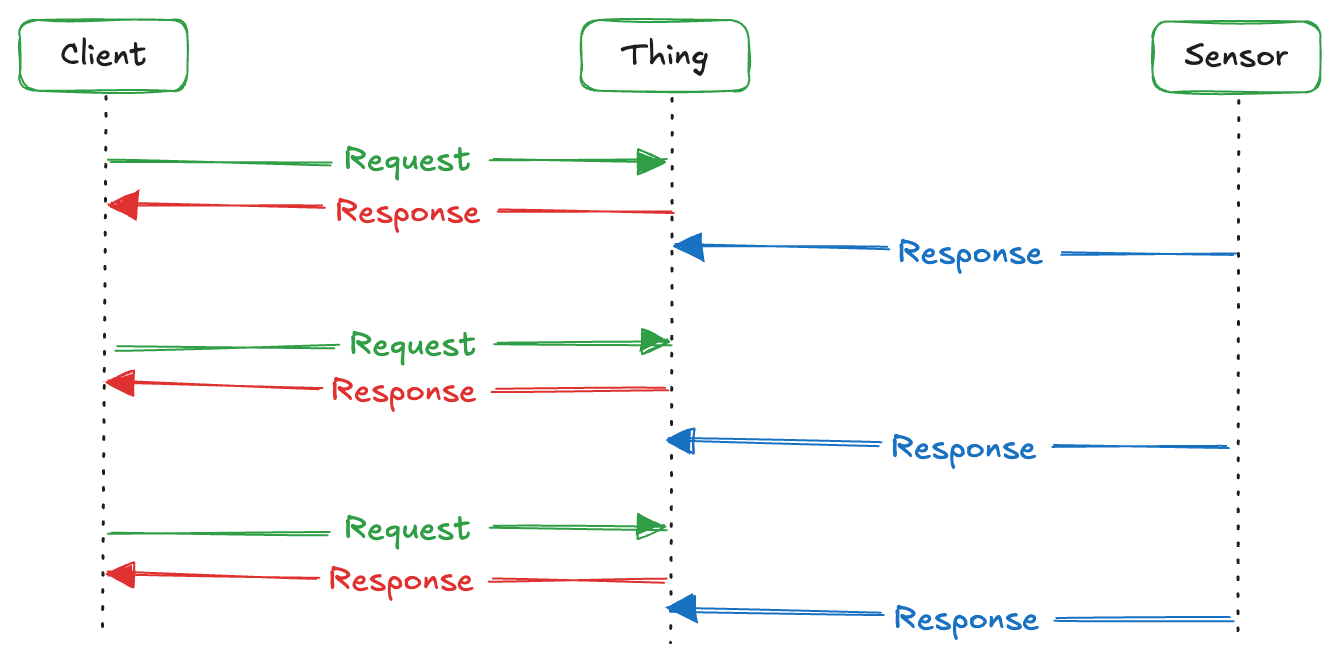

Each request asks for the latest data, such as a sensor reading, and receives a response containing the current value. The server exposes a resource (e.g., /temperature) that represents the sensor's state (see 06.polling/server.js code):

In [ ]:
const express = require('express');

const app = express();
const port = 3000;

// Simulated sensor value
let sensorValue = 0;

// REST endpoint to get sensor value
app.get('/sensor', (req, res) => {
  res.json({ value: sensorValue });
});

app.listen(port, () => { console.log(`Web Thing listening at http://localhost:${port}`); });

The client can poll this resource every few seconds to get the latest reading (see 06.polling/client.js code):

In [ ]:
const http = require('http');

function pollSensor() {
  const options = {
    hostname: 'localhost',
    port: 3000,
    path: '/sensor',
    method: 'GET',
  };

  const req = http.request(options, res => {
    let data = '';
    res.on('data', chunk => data += chunk);
    res.on('end', () => {
      try {
        const parsed = JSON.parse(data);
        console.log(`Polled Sensor Value: ${parsed.value}`);
      } 
      catch (err) { console.error('Error parsing response:', err.message);}
    });
  });

  req.on('error', err => { console.error('Request error:', err.message); });

  req.end();
}

// Poll every 2 seconds
setInterval(pollSensor, 2000);

Finally, we simulate a sensor update value every 5 seconds (see /polling/server.js code):

In [ ]:
setInterval(() => {
    sensorValue = Math.floor(Math.random() * 100);
    console.log(`Sensor updated: ${sensorValue}`);
  }, 5000);

While this approach is **simple to implement** and compatible with RESTful architectures, it has significant limitations that make it **inefficient** and **unsuitable for scalable or energy-sensitive** applications.

The primary inefficiency of basic polling lies in the **large number of redundant HTTP calls** it generates. Many of these requests yield no new information, especially when the underlying data has not changed since the last poll. This constant stream of HTTP traffic **does not scale well** with an increasing number of clients and may quickly overwhelm the server.

Moreover, basic polling is particularly **problematic for battery-powered devices**, which must minimize energy consumption and data transmission. The repeated HTTP requests not only waste network resources but also reduce battery life by forcing unnecessary communication cycles.

The client continuously issues requests to the Web Thing, which queries the underlying sensor. Even if no significant event has occurred, the server responds with the same data, leading to wasted effort on both sides. This design fails to efficiently address dynamic, event-driven scenarios and highlights the need for more advanced mechanisms.

### Publish/Subscribe pattern

In the context of the WoT), real-time responsiveness is essential to support applications that need to react promptly to dynamic conditions, such as motion detection, alarm triggering, or sensor value thresholds. The traditional REST model, which relies on a client-server request/response interaction, falls short when it comes to efficiently managing these asynchronous and event-driven scenarios. To overcome this limitation, the **publish/subscribe (Pub/Sub) model** emerges as a powerful architectural pattern. The pattern introduces a fundamental decoupling between data **producers** (**publishers**) and data **consumers** (**subscribers**). Instead of clients repeatedly polling for new data, publishers send messages to a central component called a **broker**, which is responsible for routing and distributing these messages to the appropriate subscribers. Subscribers express their interest in specific types of events or data (e.g., subscribing to temperature or motion updates), and the broker ensures that they receive relevant updates as soon as they are published:

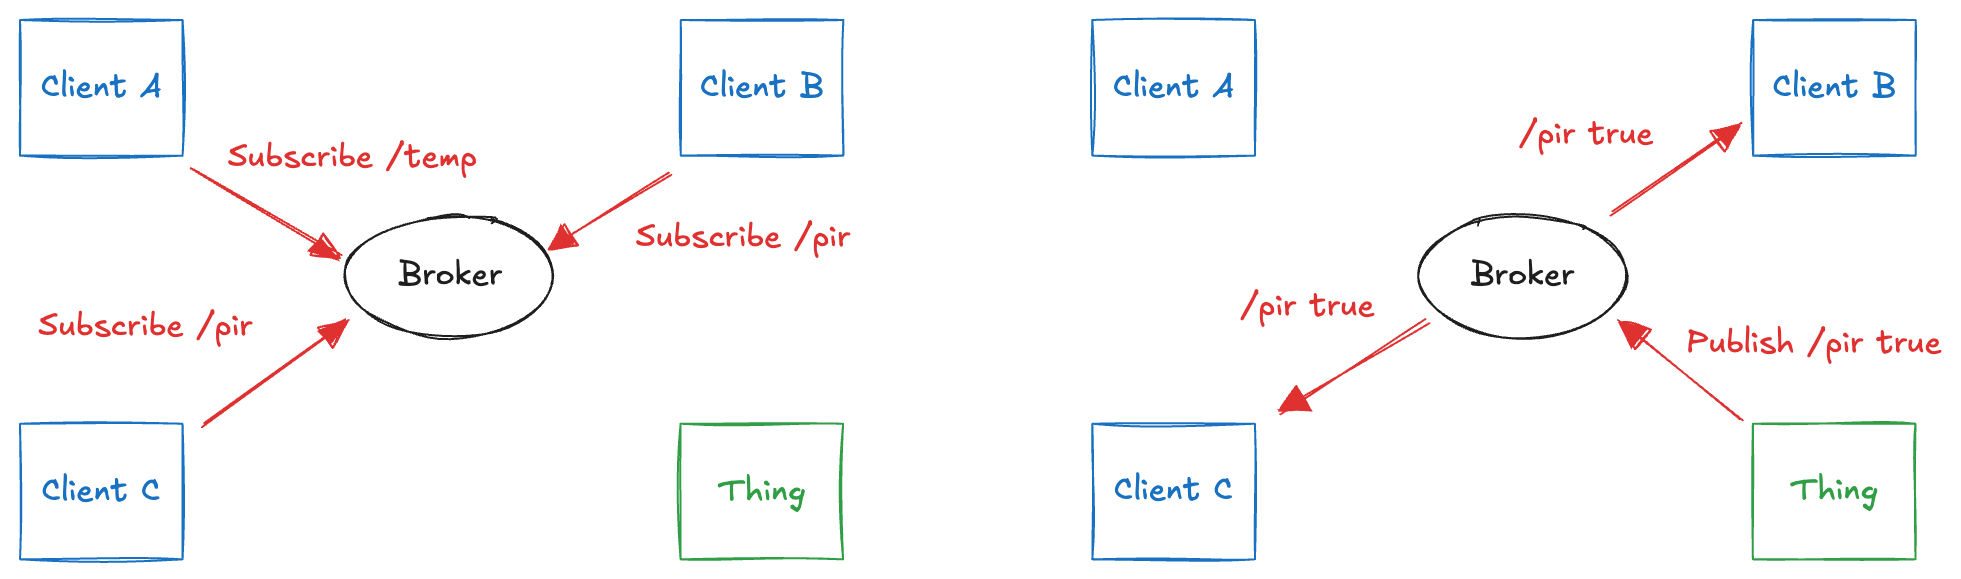

This mechanism supports highly scalable and dynamic environments, where clients may come and go, and publishers may emit a wide variety of data. The analogy to a chat room is particularly apt: some channels are public, others are private, and communication can be one-to-one or one-to-many, depending on the nature of the subscriptions.

To implement this pattern on the Web, several technologies can be leveraged. Among the most popular are **WebHooks**, **Long Polling**, and **WebSockets**, each with different trade-offs in terms of latency, complexity, and compatibility. These technologies enable the broker to push data to clients as soon as it becomes available, providing a foundation for reactive and responsive WoT applications.

### WebHooks

**WebHooks** are a simple and effective way to implement server-to-server communication in an event-driven architecture. Unlike basic polling, where the client repeatedly requests updates, WebHooks reverse the flow: the server (the Thing) actively sends updates to a client-provided URL when something relevant occurs:

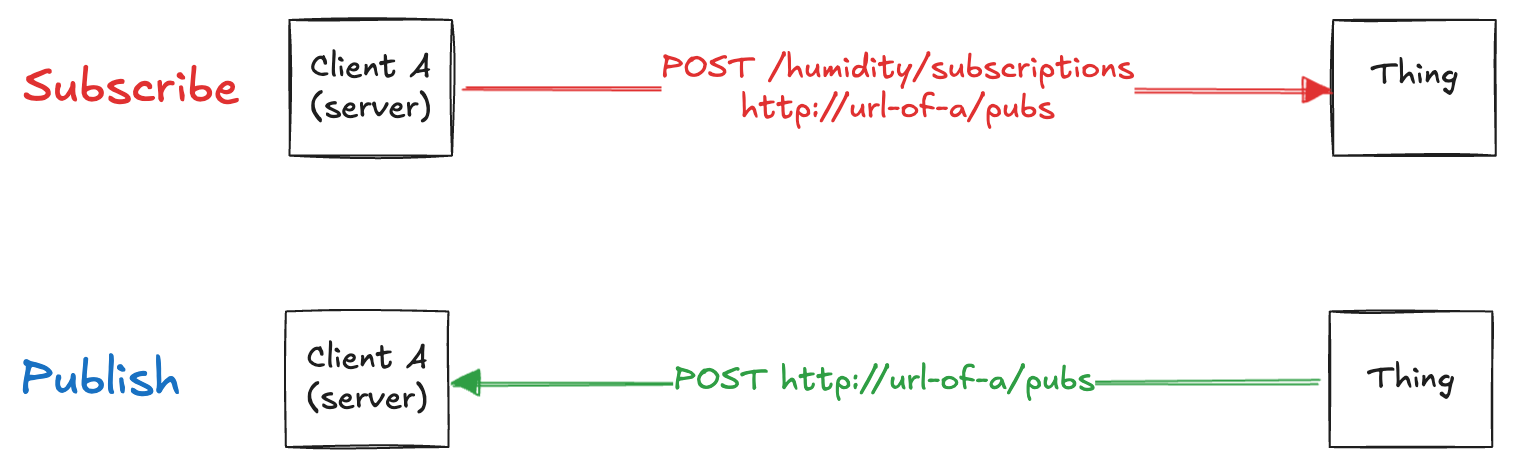

This approach treats every entity (both the device and the client) not only **as a consumer** but also as **a potential server**. The client exposes an endpoint and subscribes by telling the Thing where to send updates (e.g., a URL). When the event occurs, the Thing sends an HTTP POST request with the relevant data directly to that endpoint. This model is widely used across the web, for example, by PayPal to notify other systems when a payment is processed. 

The main limitation is that the subscriber (client) must be accessible from the public internet. This makes it difficult to use in scenarios involving private networks, mobile apps, or battery-powered IoT devices.

We can write a simple publisher that take care of registering the subscriber and sending the updates (see 07.webhook/publisher.js code):

In [ ]:
const express = require('express');
const http = require('http');

const app = express();
app.use(express.json());
const port = 3000;

const subscribers = [];

// Endpoint to subscribe to events
app.post('/subscribe', (req, res) => {
    const { url } = req.body;
    if (!url) { return res.status(400).json({ error: 'Missing URL in request body' }); }
    subscribers.push(url);
    res.status(201).json({ message: 'Subscribed successfully' });
});

// Internal function to push events to all subscribers
function publishEvent(value) {
  const data = JSON.stringify(value);

  // Send the event to all subscribers
  subscribers.forEach(subscriberURL => {

    // Parse the URL to get the hostname and port
    const { hostname, port, pathname } = new URL(subscriberURL);

    // Create an HTTP request to the subscriber
    const options = {
      hostname: hostname,
      port: parseInt(port, 10),
      path: pathname,
      method: 'POST',
      headers: {
        'Content-Type': 'application/json',
        'Content-Length': data.length
      }
    };

    // Send the request to the subscriber
    const req = http.request(options, res => { console.log(`Event sent to ${subscriberURL} - Status: ${res.statusCode}`);});
    req.on('error', err => { console.error(`Error sending to ${subscriberURL}:`, err.message); });
    req.write(data);
    req.end();
  });
}

app.listen(port, () => { console.log(`Thing server running at http://localhost:${port}`); });

We simulate a sensor update value every 5 seconds and when the event occurs, we send an HTTP POST request to the subscriber URL (see 07.webhook/publisher.js code):

In [ ]:
setInterval(() => {

  // Simulate a sensor event
  const event = {
    sensor: 'humidity',
    value: Math.floor(Math.random() * 100),
    timestamp: new Date().toISOString()
  };

  // Log the event and publish it to subscribers
  console.log('Publishing event:', event);
  publishEvent(event);
}, 5000);

An a simple subscriber that receives the updates (see 07.webhook/subscriber.js code):

In [ ]:
const express = require('express');
const http = require('http');
const app = express();
const port = 5001;

app.use(express.json());

// Webhook endpoint to receive events
app.post('/webhook', (req, res) => {
  console.log('Received event:', req.body);
  res.sendStatus(204);
});

// Server to listen for incoming events
app.listen(port, () => {
  console.log(`Subscriber listening on http://localhost:${port}/webhook`);

  // Automatically subscribe to the Thing
  const data = JSON.stringify({ url: `http://localhost:${port}/webhook` });

  const options = {
    hostname: 'localhost',
    port: 3000,
    path: '/subscribe',
    method: 'POST',
    headers: {
      'Content-Type': 'application/json',
      'Content-Length': data.length
    }
  };

  const req = http.request(options, res => { console.log(`Subscribed to Thing - Status: ${res.statusCode}`);});
  req.on('error', err => { console.error('Error subscribing:', err.message); });
  req.write(data);
  req.end();
});

This example shows how WebHooks can mimic a lightweight Pub/Sub mechanism using only HTTP. It's simple and compatible with REST principles, but remember: it requires the client to be accessible over the network, which is not always practical in WoT scenarios.

### Long Polling

**Long polling** is a technique that improves on basic polling by keeping the client’s HTTP request **open** until the server has data available to return. This reduces unnecessary traffic and latency, allowing near real-time communication between devices. When the client sends a request, the server holds it open and responds only when an event occurs. The client then immediately opens a new request to wait for the next event.

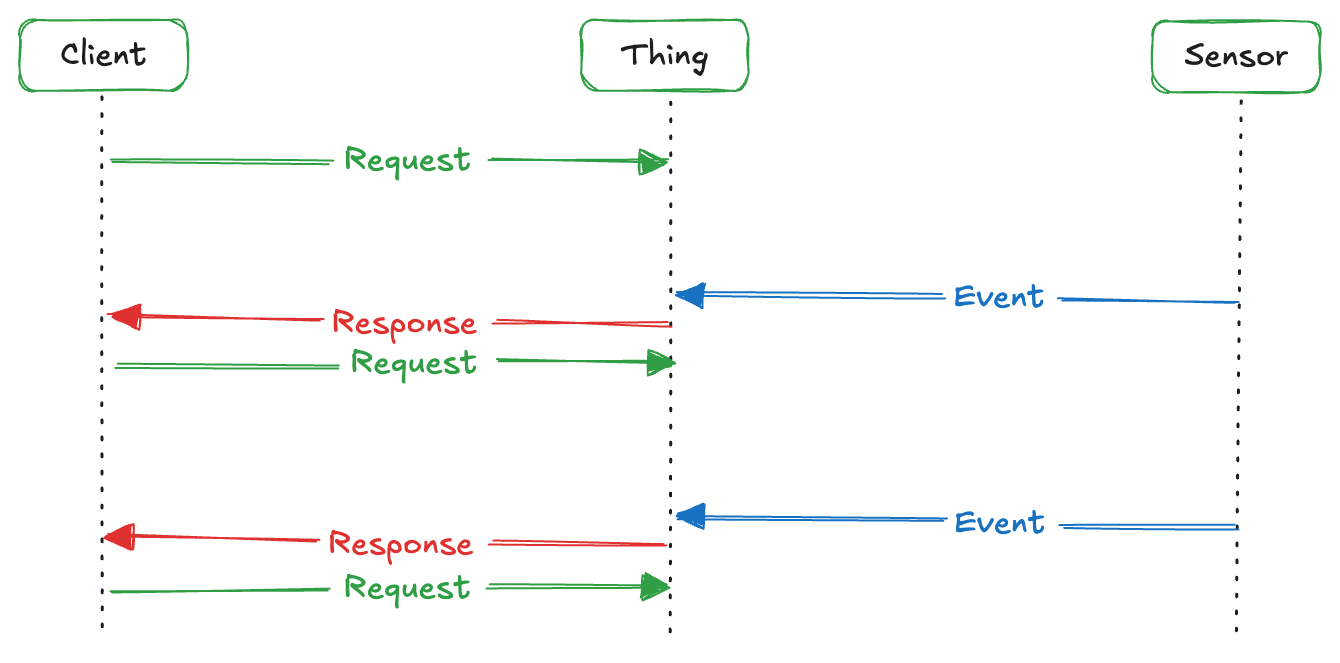

It is a practical **workaround** to achieve near real-time communication over HTTP, but it comes with **notable limitations** that must be considered, especially in the context of the Web of Things. One major issue is the **connection overhead**: each client maintains an open connection while waiting for a server response, which consumes server resources such as memory and sockets. As the number of connected clients grows, this can lead to scalability challenges and performance degradation. Another limitation lies in the **reconnection cycle**. After each event is delivered, the client must immediately re-establish a new connection. Although this reduces idle requests compared to basic polling, it still introduces unnecessary network traffic and overhead due to repeated connection setups and teardowns. 

Here a simple implementation of a long polling server (see 08.longpolling/server.js code):


In [ ]:
const express = require('express');
const app = express();
const port = 3000;

// The latest event to be sent to clients
let latestEvent = null;

// The list of clients waiting for events
let waitingClients = [];

// Long polling endpoint
app.get('/events', (req, res) => {
  
  // Save the response object to respond later
  waitingClients.push(res);

  // Timeout after 25 seconds to avoid broken connections
  req.setTimeout(25000, () => {
    const index = waitingClients.indexOf(res);
    if (index !== -1) waitingClients.splice(index, 1);
    res.status(204).end(); // No Content
  });
});

app.listen(port, () => { console.log(`Thing running on http://localhost:${port}`); });

We simulate a new hevent every 5 seconds and send it as a JSON response to all clients waiting for updates. After responding, we clear the list of waiting clients (see 08.longpolling/server.js code):

In [ ]:
setInterval(() => {
  
  // Simulate a sensor event
  latestEvent = {
    sensor: 'humidity',
    value: Math.floor(Math.random() * 100),
    timestamp: new Date().toISOString()
  };
  console.log('New event:', latestEvent);

  // Respond to all waiting clients
  waitingClients.forEach(res => res.json(latestEvent));
  waitingClients = []; // Clear list
}, 5000);

This client repeatedly sends GET requests to `/events` on the server. If a new event is received (status 200 with data), it logs the event and immediately polls again. If no event is received or a timeout occurs, it retries (see 08.longpolling/client.js code):

In [ ]:
const http = require('http');

// Create a polling request
function poll() {
  const options = {
    hostname: 'localhost',
    port: 3000,
    path: '/events',
    method: 'GET'
  };

  // Send the request to the server
  const req = http.request(options, res => {
    let data = '';

    res.on('data', chunk => data += chunk);

    // Handle the end of the response
    res.on('end', () => {
      if (res.statusCode === 200 && data) {
        const event = JSON.parse(data);
        console.log('Received event:', event);
      } 
      else { console.log('No new event (timeout).'); }
      
      // Immediately reconnect after receiving response
      poll();
    });
  });

  req.on('error', err => {
    console.error('Polling error:', err.message);
    // Retry after delay
    setTimeout(poll, 2000); 
  });

  req.end();
}

// Start polling loop
poll(); 

### WebSockets

**WebSockets** represent a modern, **efficient solution** for real-time, bidirectional communication between clients and servers. Unlike long polling, which simulates reactivity by repeatedly opening and closing HTTP connections, WebSockets **establish a persistent TCP connection** that remains open, allowing data to flow in both directions as events occur. This makes WebSockets particularly well-suited for applications in the Web of Things, where devices must frequently send and receive timely updates.

The WebSocket protocol begins with a standard HTTP request containing an **upgrade header**. If the server supports WebSockets, it responds with a **101 Switching Protocols status code**. Once the handshake completes, the connection transitions from HTTP to **a full-duplex TCP channel**. From this point forward, both the client and server can asynchronously push messages to each other using WebSocket frames instead of traditional HTTP requests and responses. The communication overhead is minimal: each frame requires only a 2-byte header, a substantial improvement over HTTP’s verbose structure:

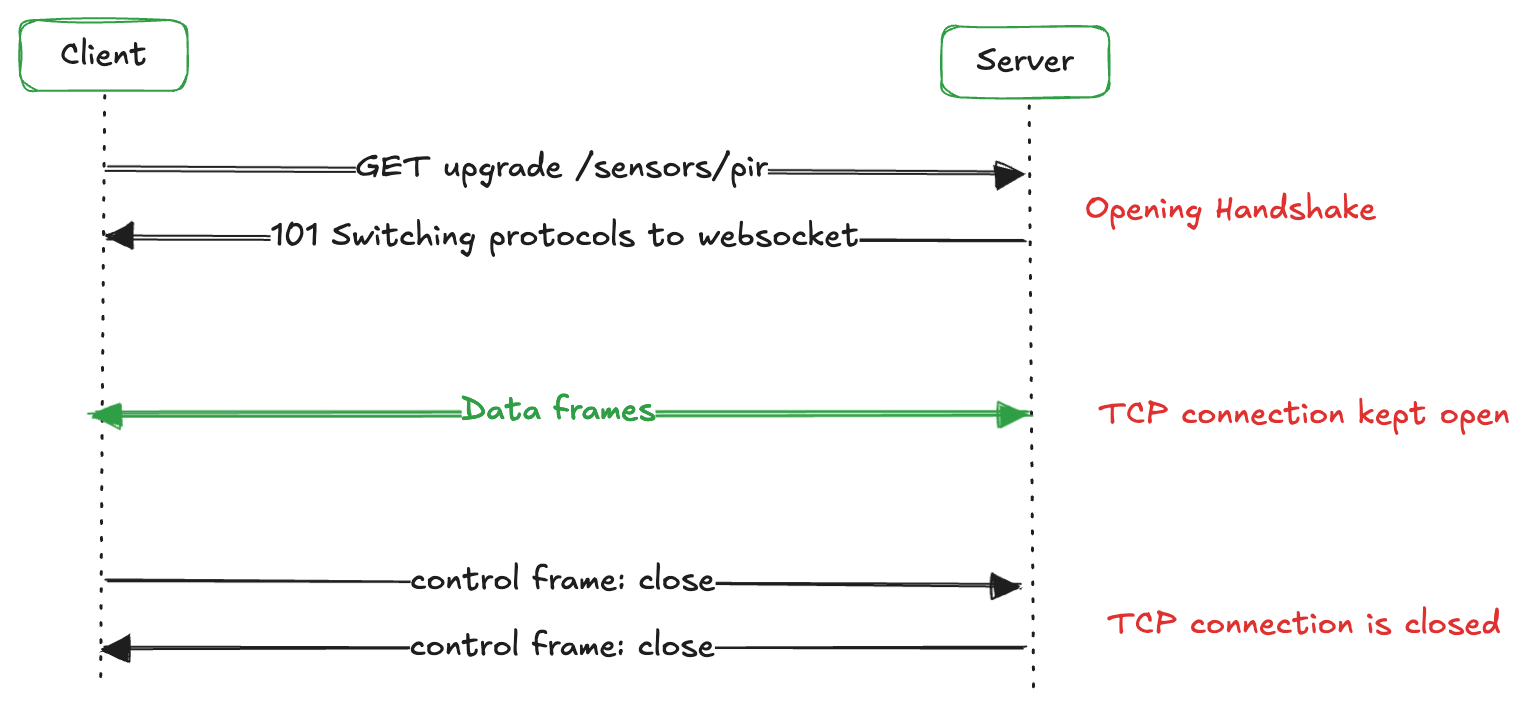

This lightweight, always-on channel is ideal for scenarios where latency, responsiveness, and resource efficiency are critical, such as controlling actuators, receiving sensor updates, or broadcasting events to multiple devices. WebSockets overcome the limitations of polling and long polling by providing true push-based communication with minimal delay and network overhead.

NodeJS provides a built-in WebSocket library called **ws** that simplifies the implementation of WebSocket servers and clients. The library allows developers to create real-time applications with ease, enabling them to handle multiple connections, broadcast messages, and manage events efficiently. Here's a simple example of a WebSocket server and client using the ws library (see 09.websocket/server.js code):

In [ ]:
const WebSocket = require('ws');

// Create a WebSocket server
const wss = new WebSocket.Server({ port: 3000 });

// Array to hold connected clients
let clients = [];

// Handle WebSocket connections
wss.on('connection', ws => {
  console.log('Client connected');

  // Add the new client to the array
  clients.push(ws);

  // Manage closing connections
  ws.on('close', () => {
    console.log('Client disconnected');
    clients = clients.filter(client => client !== ws);
  });
});

As before, the code simulates an event every 5 seconds and broadcasts it as a JSON message to all connected WebSocket clients that are still open (see 09.websocket/server.js code)::

In [ ]:
setInterval(() => {

  // Simulate a sensor event
  const event = {
    sensor: 'humidity',
    value: Math.floor(Math.random() * 100),
    timestamp: new Date().toISOString()
  };
  console.log('Broadcasting:', event);
  
  // Send the event to all connected clients
  const message = JSON.stringify(event);
  clients.forEach(ws => {
    if (ws.readyState === WebSocket.OPEN) { ws.send(message); }
  });

}, 5000);

The client code creates a WebSocket that connects to the server, logs when it's connected or disconnected, and prints any received sensor event. It also handles and logs connection errors (see 09.websocket/client.js code):

In [ ]:
const WebSocket = require('ws');

// Create a WebSocket client
const ws = new WebSocket('ws://localhost:3000');

// Handle WebSocket events
ws.on('open', () => { console.log('Connected to WebSocket server'); });

ws.on('message', data => {
  const event = JSON.parse(data);
  console.log('Received event:', event);
});

ws.on('close', () => { console.log('Disconnected from server'); });

ws.on('error', err => { console.error('WebSocket error:', err.message); });

## Hands-on Activity

Design and implement (using NodeJS and Express) a RESTful API to manage a university course. You have to design resources (like students, exams, grades, etc.), routes (taking into account hierarchy, like /students/id/exams), representations (the JSON body of each resource). We don’t have any database technology until now, so, please keeps data in memory using arrays.